# Survey statistics

In [ ]:
from db import query
from dr_downloader import survey_years
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from astropy.time import Time
import numpy as np
import seaborn as sns 
import numpy as np

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}

In [3]:
regions = {
    "NEO": "q <= 1.3",
    "Main Belt": "(mpc.e <1) and (mpc.q/(1-mpc.e) >= 1.6) and (mpc.q/(1-mpc.e) <= 4.2 and mpc.q>=1.3)",
    "Jupiter Trojans": "(mpc.q/(1-mpc.e) >= 5.05) and (mpc.q/(1-mpc.e) <= 5.35)" #5.05 and 5.35 AU
}

In [6]:
years = survey_years() # cache this

bands = np.array([["g", "r", "i", "z"] for i in range(len(years))]).reshape(1, 4*len(years)).tolist()[0]

catalog_delta = years[0].value[1][0] - years[0].value[0][0] # Time epoch for first year catalog
catalog_dates = []
catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0]], format="mjd"))

for i in range(1, 8):
    catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0] + (i)*catalog_delta], format="mjd"))
catalog_dates.append(Time([years[0].value[0][0], \
                years[-1].value[1][0]], format="mjd"))

In [7]:
catalog_detection_counts = []

for date in catalog_dates:
    stmt = f'''
    select count(*)
    from dp03_catalogs_10yr.DiaSource as DiaSource
    where midPointMjdTai >= {date[0]} and midPointMjdTai <= {date[1]}
    '''
    detection_count = query(stmt)
    catalog_detection_counts.append(detection_count["count"])

Text(0.5, 0, 'Year of survey')

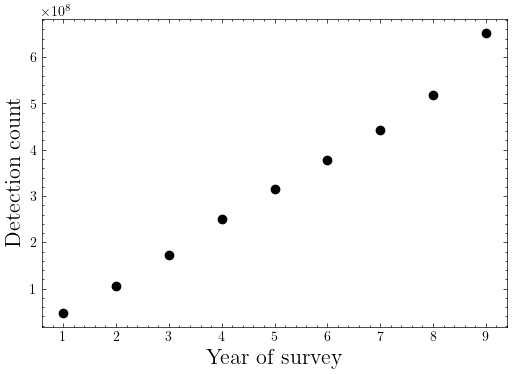

In [8]:
plt.figure(figsize=(6, 4))

plt.scatter(
    [i for i in range(1,10)],
    catalog_detection_counts,
    c="black"
)
plt.ylabel("Detection count", fontsize=16)
plt.xlabel("Year of survey", fontsize=16)

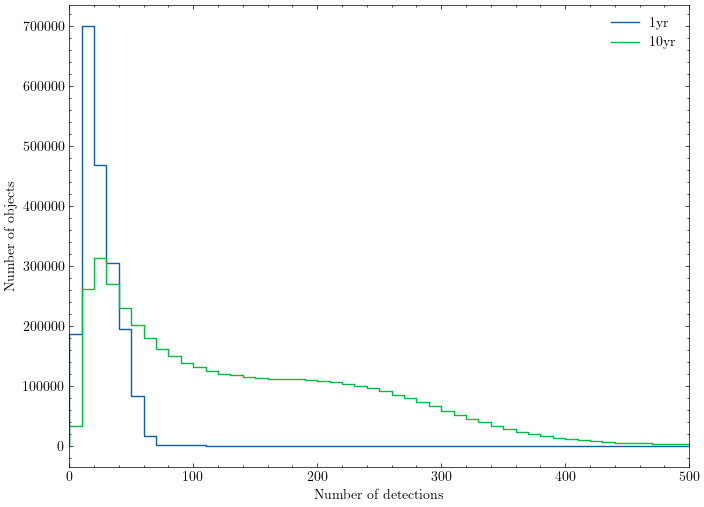

In [9]:
plt.figure(figsize=(8,6))

for catalog in ["dp03_catalogs_1yr","dp03_catalogs_10yr"]:
    stmt = f'''
        select count(distinct ssObjectId), numObs
        from {catalog}.SSObject
        group by numObs
        '''
    counts = query(stmt)
    delta = 10
    
    bins = np.arange(0, counts["numObs"].max(), delta)
    df = counts.to_table().to_pandas()
    bin_counts = [df[(df["numObs"] >= bins[i]) & (df["numObs"] < bins[i + 1])].sum()["count"] for i in range(0, len(bins) - 1)]

    plt.step(
        bins,
        [0] + bin_counts,
        label=catalog.split("dp03_catalogs_")[1]
    )

plt.xlim(0,500)
plt.xlabel("Number of detections")
plt.ylabel("Number of objects")
plt.legend()

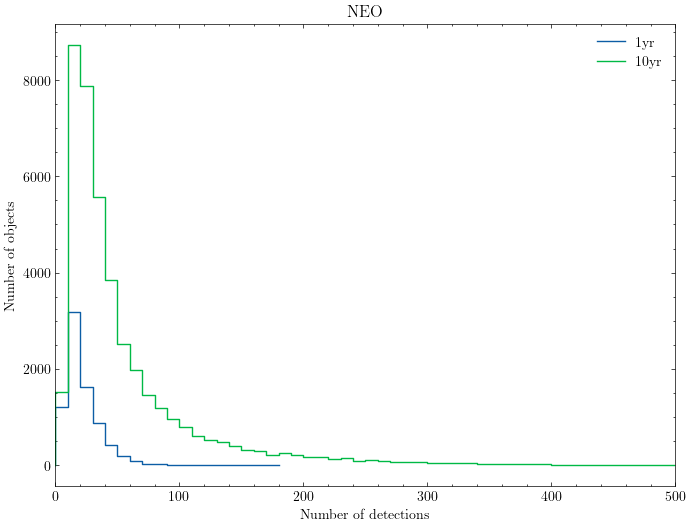

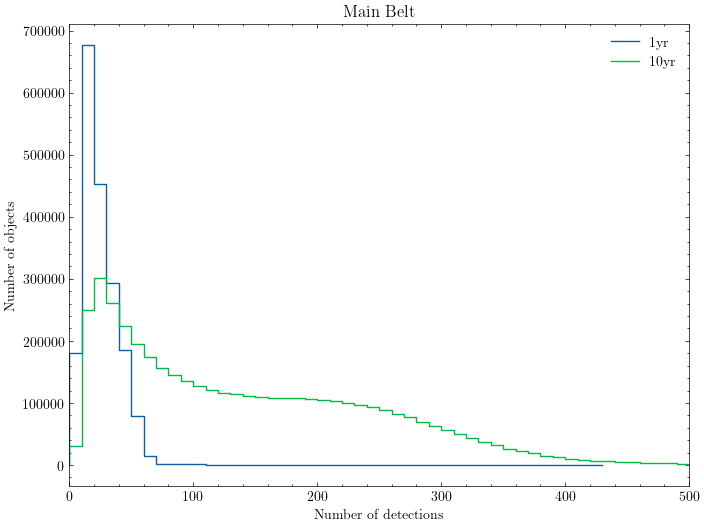

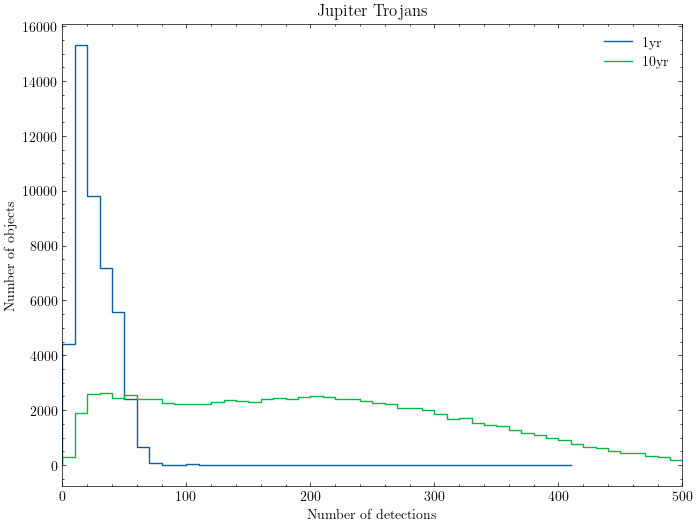

In [10]:
for region, condition in regions.items():
    plt.figure(figsize=(8,6))

    for catalog in ["dp03_catalogs_1yr","dp03_catalogs_10yr"]:
        stmt = f'''
            select count(distinct sso.ssObjectId), numObs
            from {catalog}.SSObject as sso
            join {catalog}.MPCORB as mpc on mpc.SSObjectId = sso.SSObjectId
            where {condition}
            group by numObs
            '''
        counts = query(stmt)
        delta = 10
        
        bins = np.arange(0, counts["numObs"].max(), delta)
        df = counts.to_table().to_pandas()
        bin_counts = [df[(df["numObs"] >= bins[i]) & (df["numObs"] < bins[i + 1])].sum()["count"] for i in range(0, len(bins) - 1)]

        plt.step(
            bins,
            [0] + bin_counts,
            label=catalog.split("dp03_catalogs_")[1]
        )

    plt.xlim(0,500)
    plt.xlabel("Number of detections")
    plt.ylabel("Number of objects")
    plt.legend()
    plt.title(f"{region}")

/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_66619/1327460452.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, figsize=(10,8))


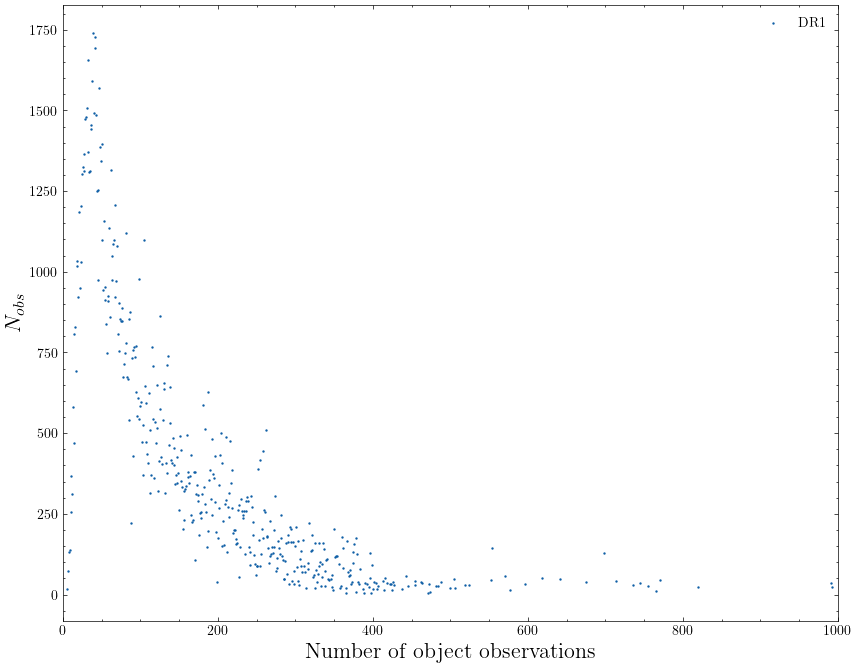

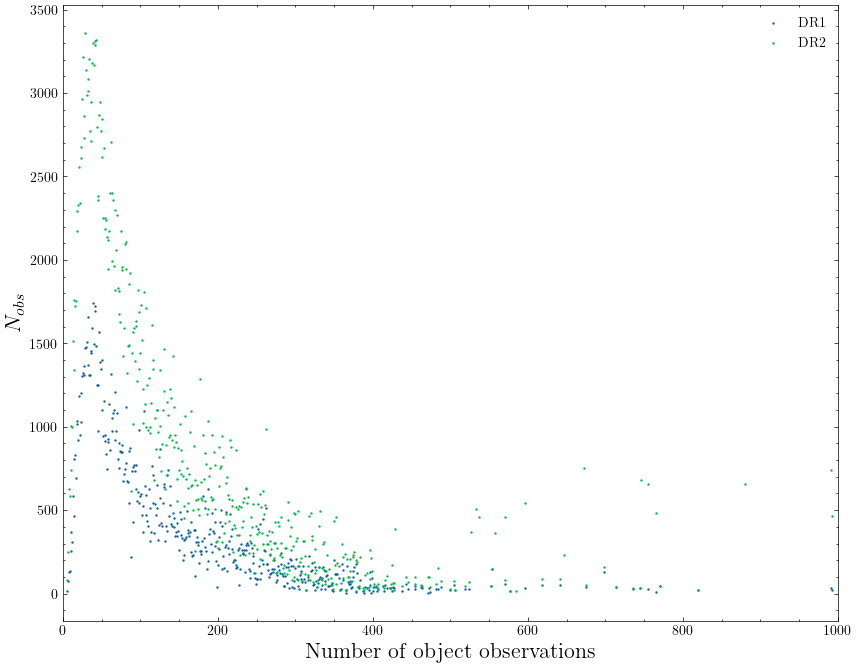

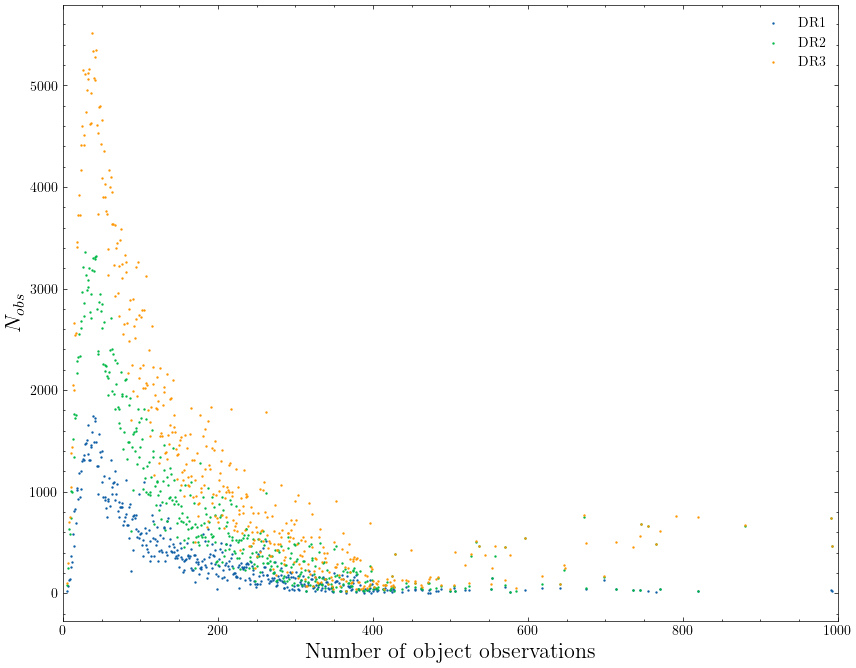

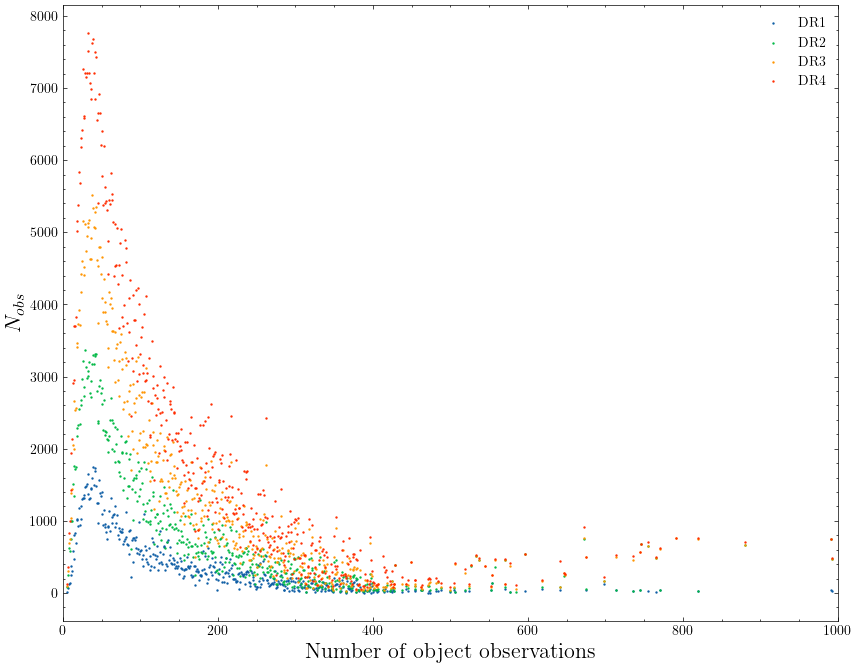

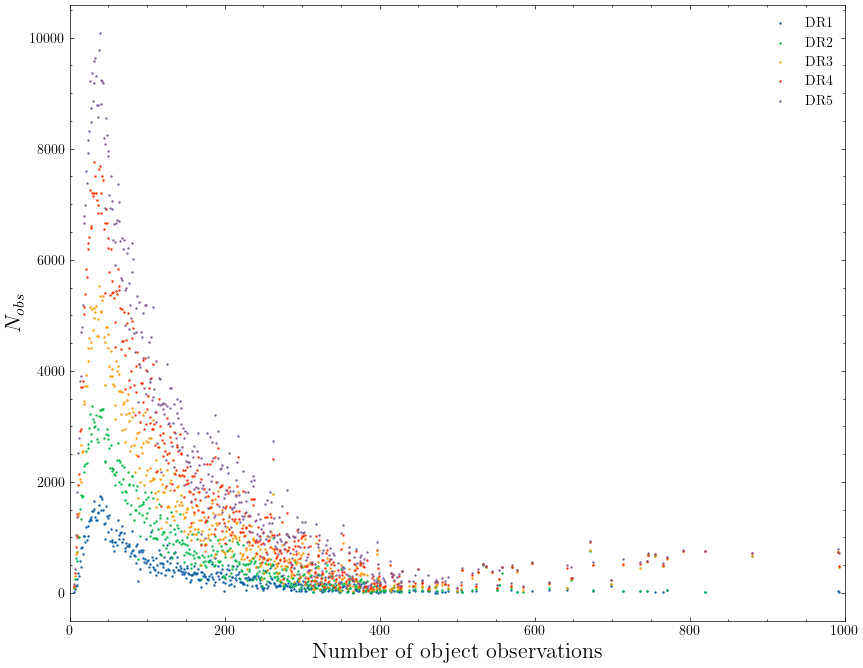

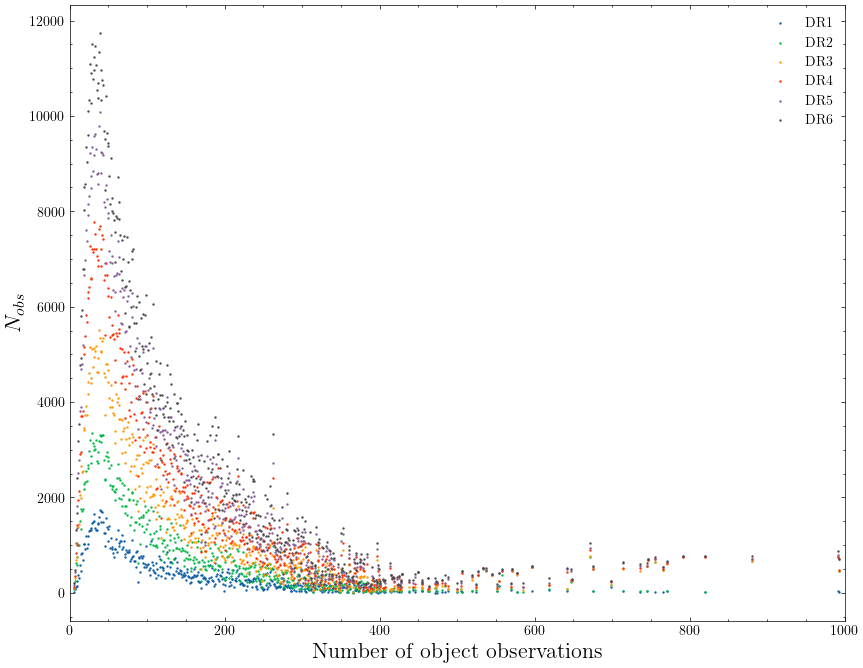

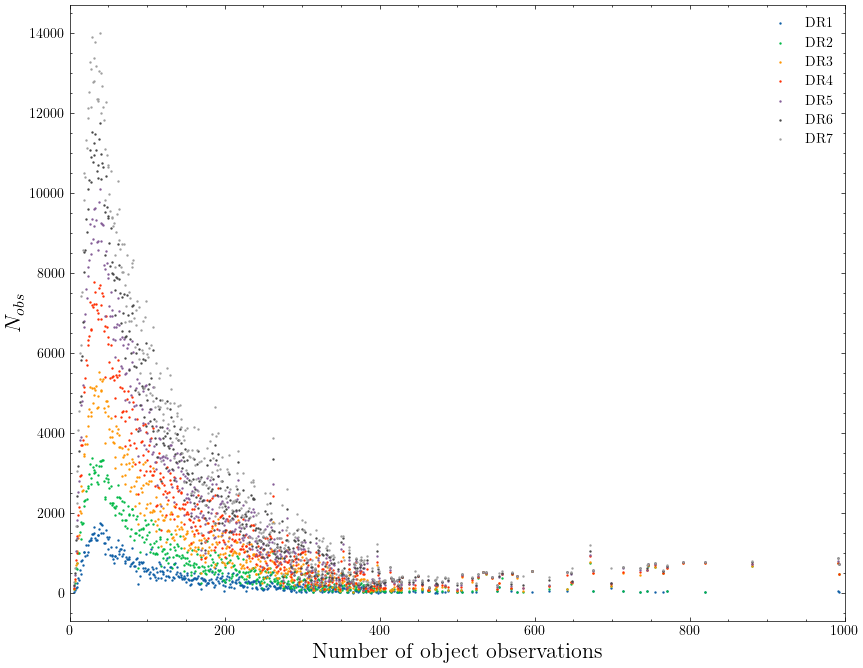

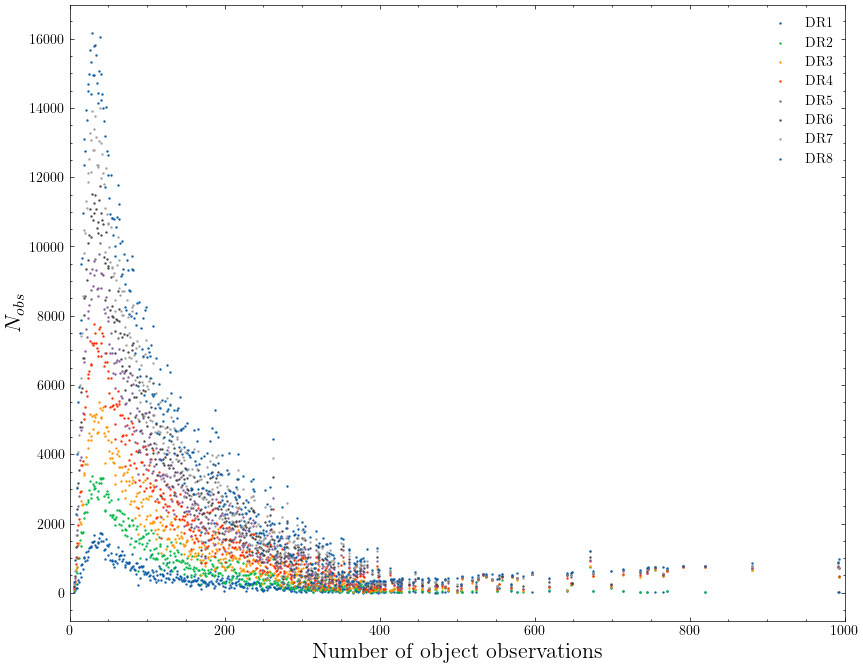

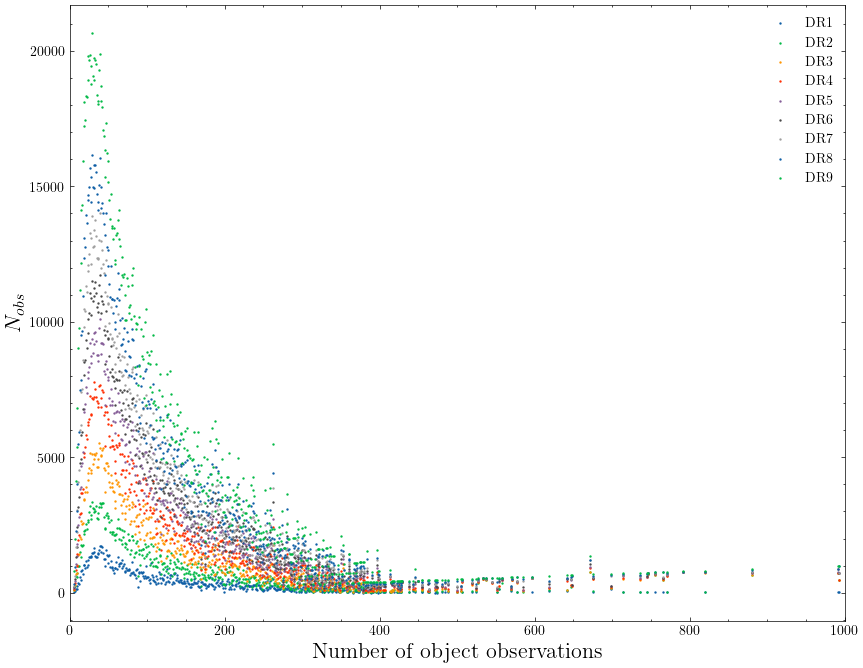

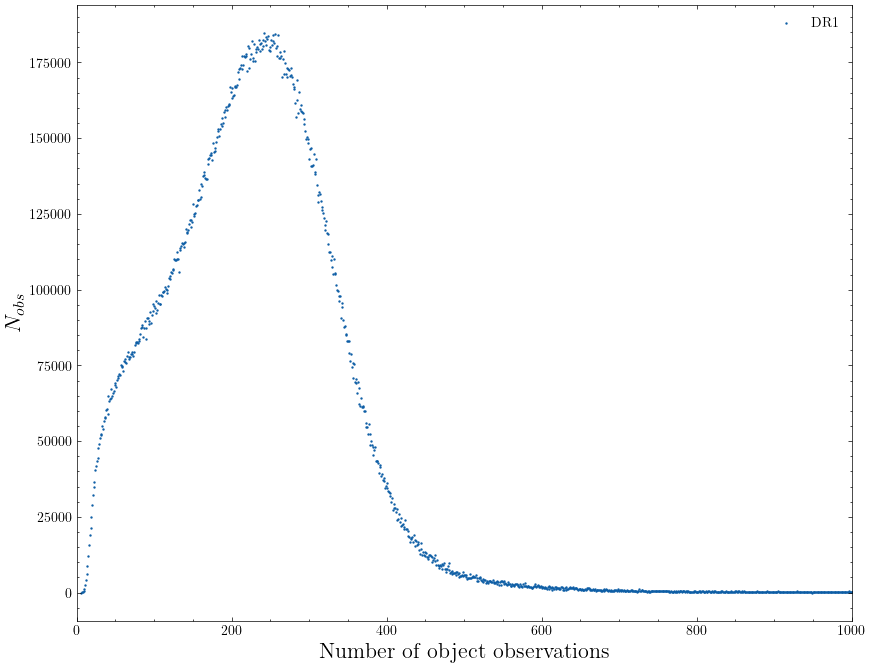

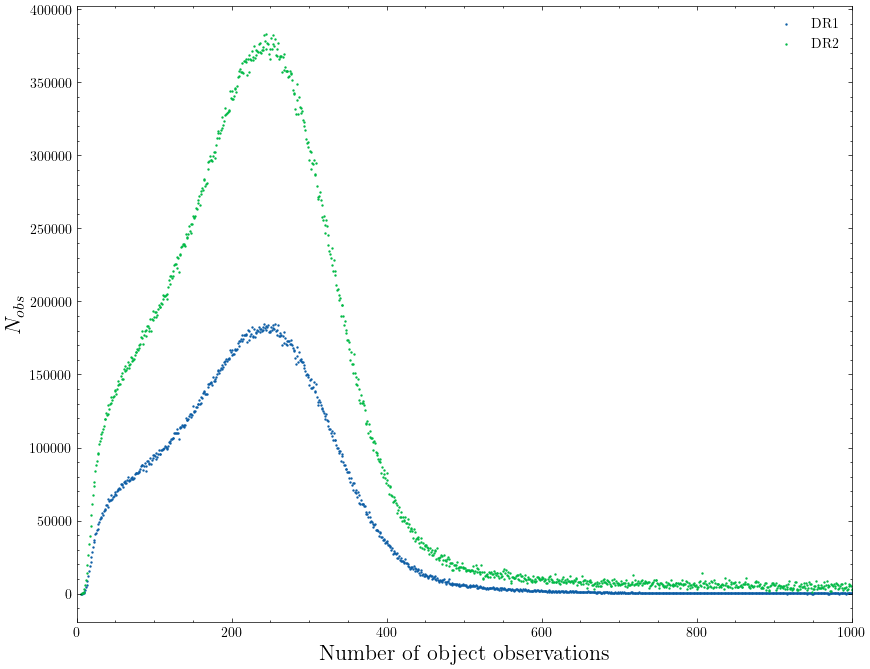

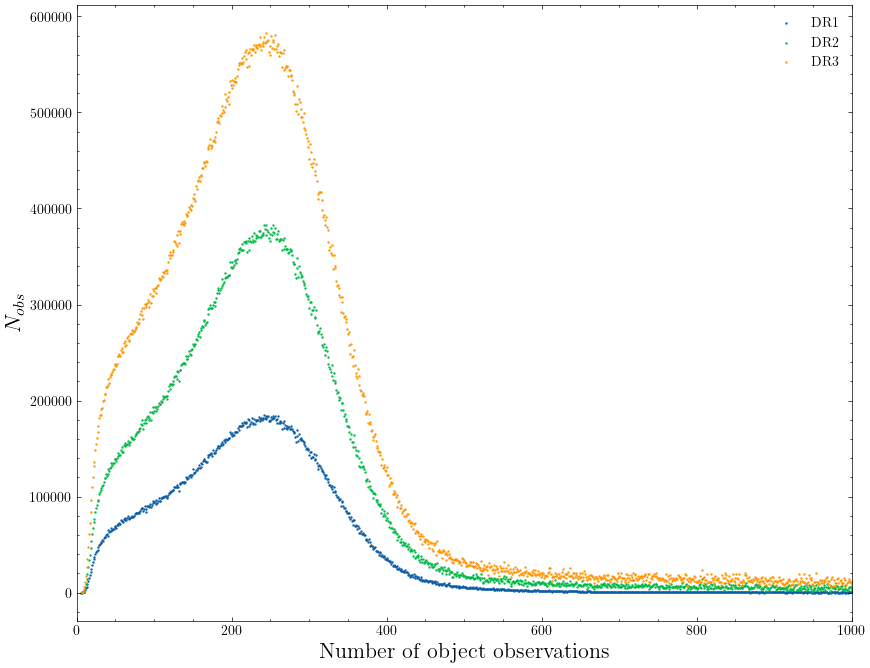

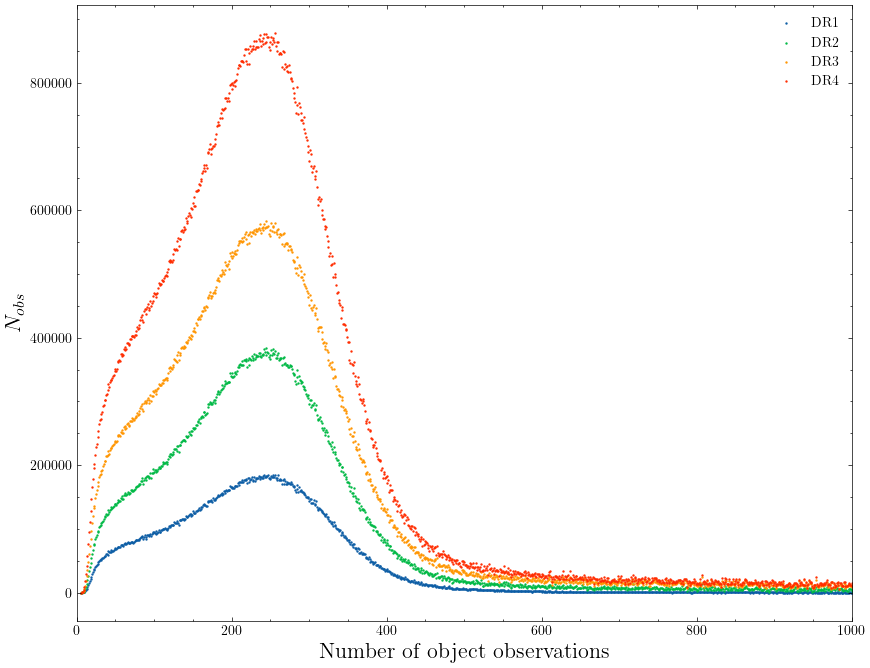

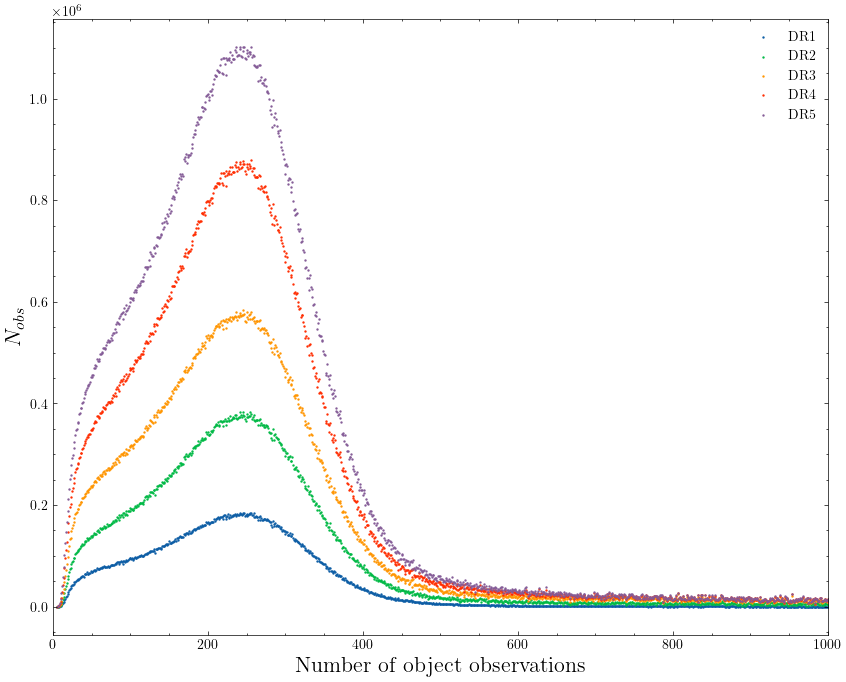

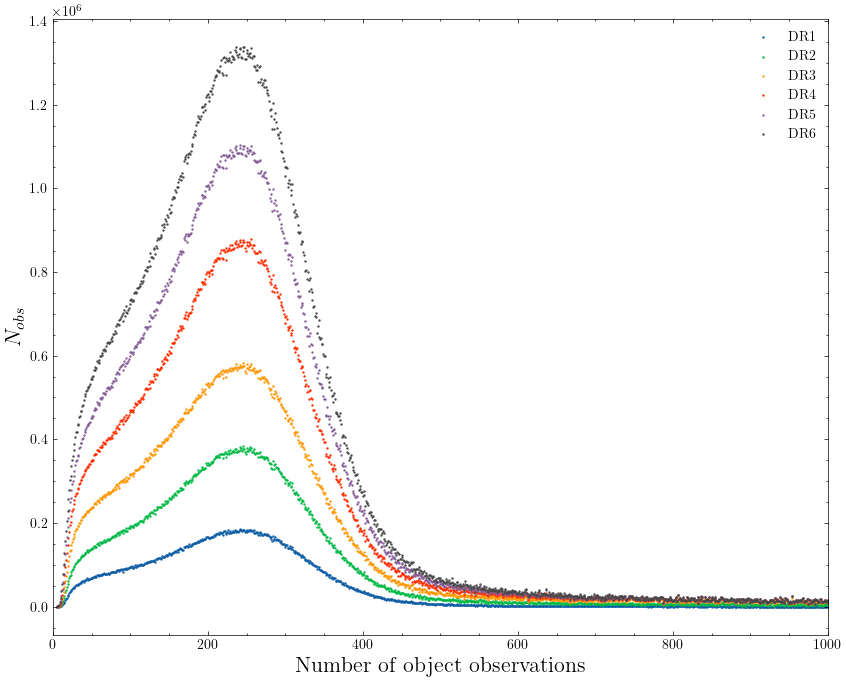

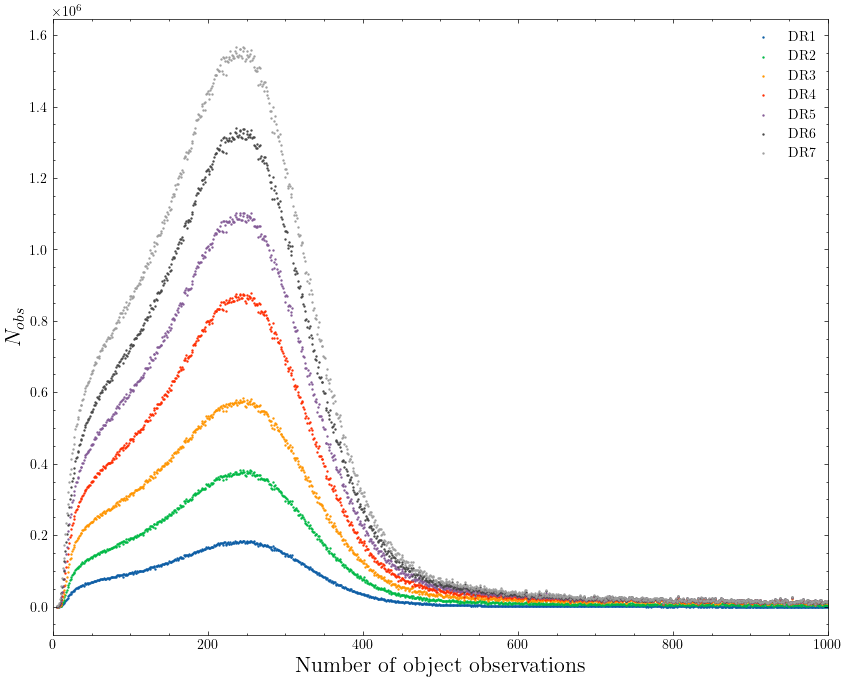

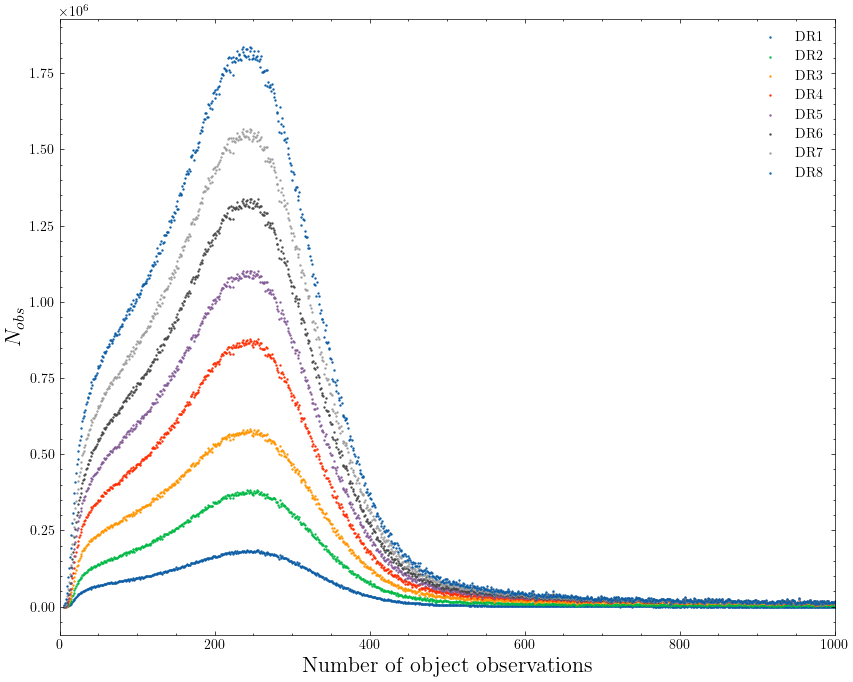

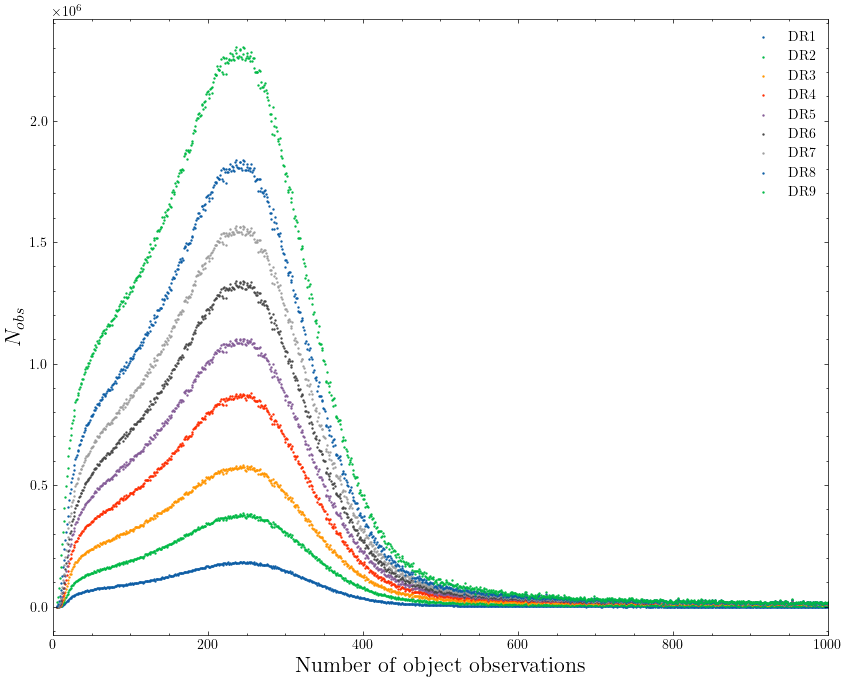

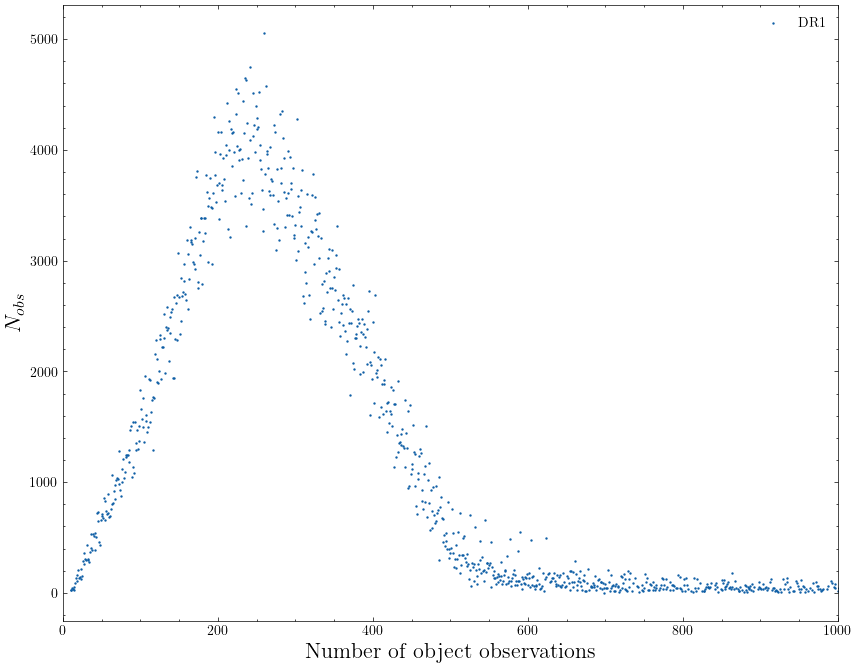

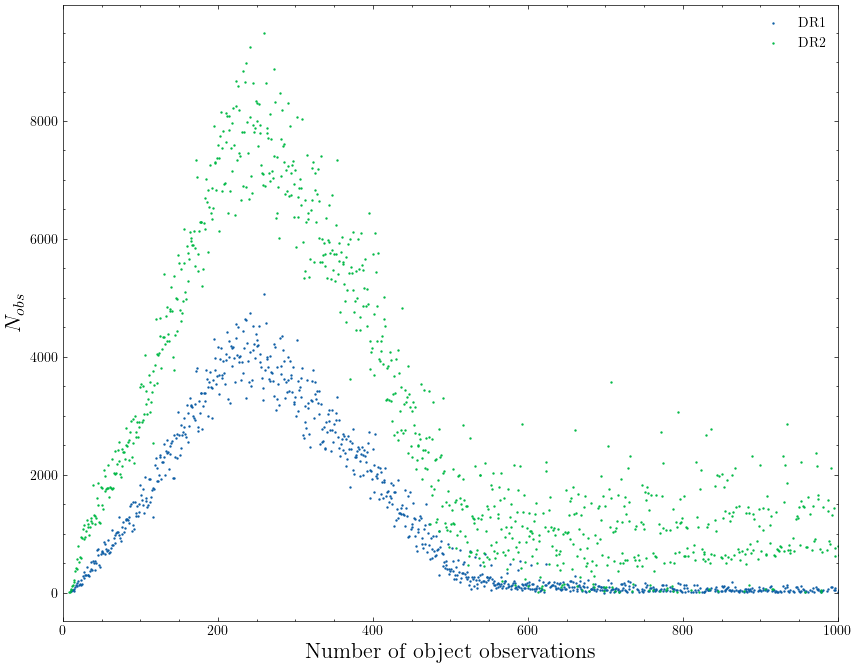

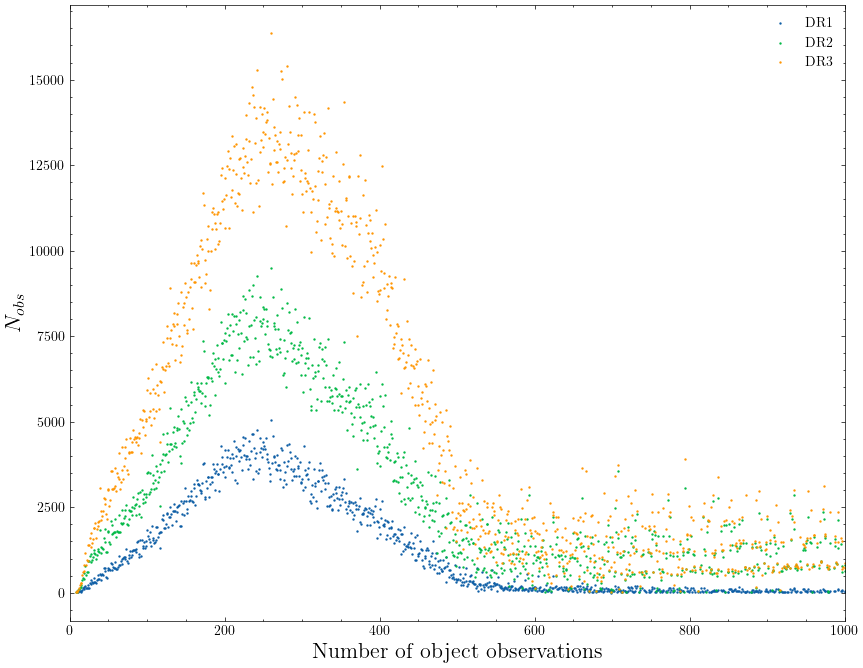

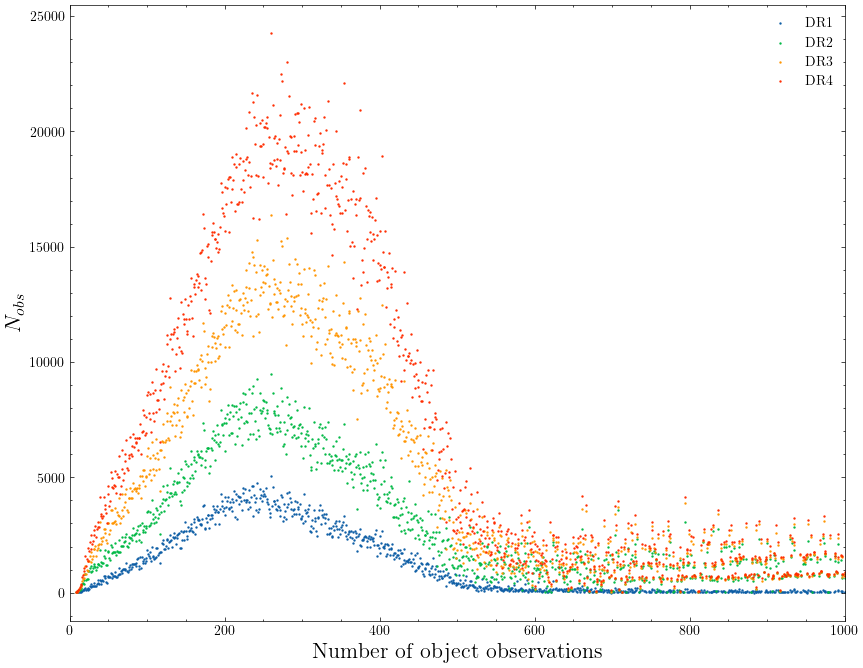

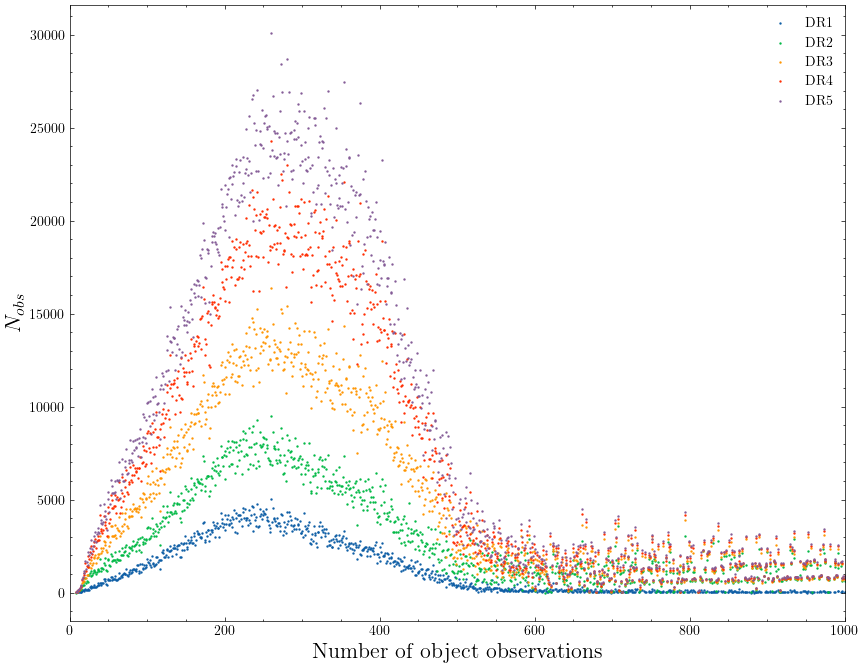

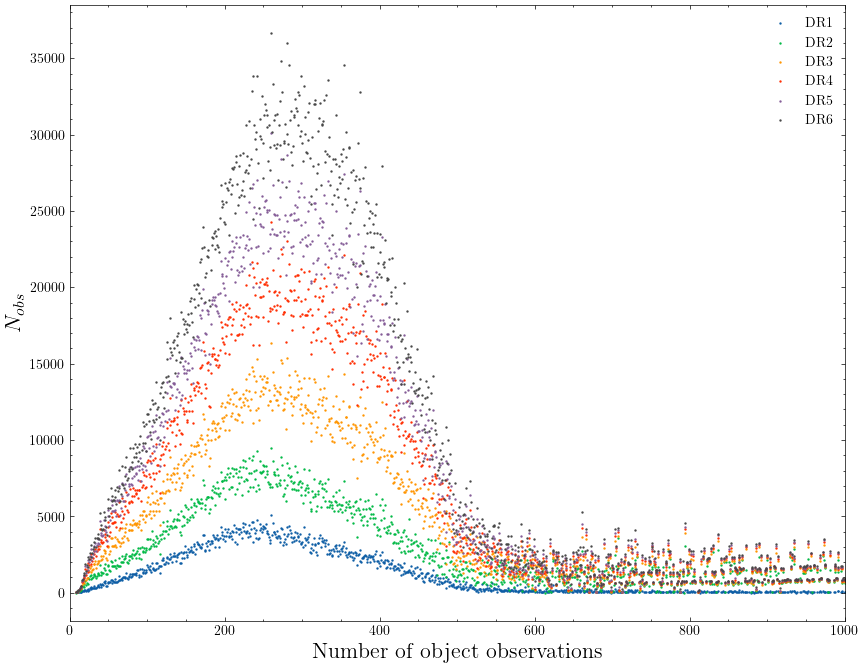

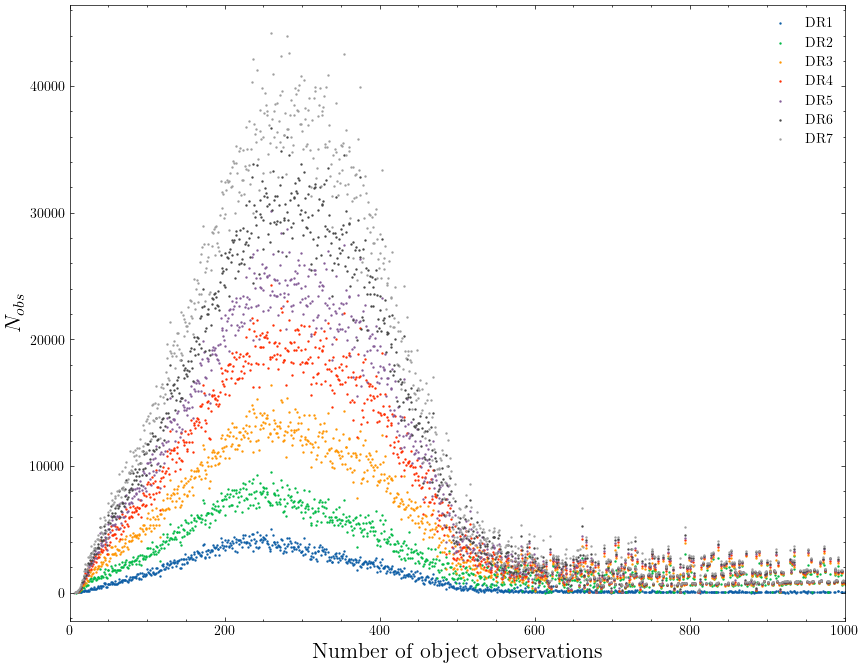

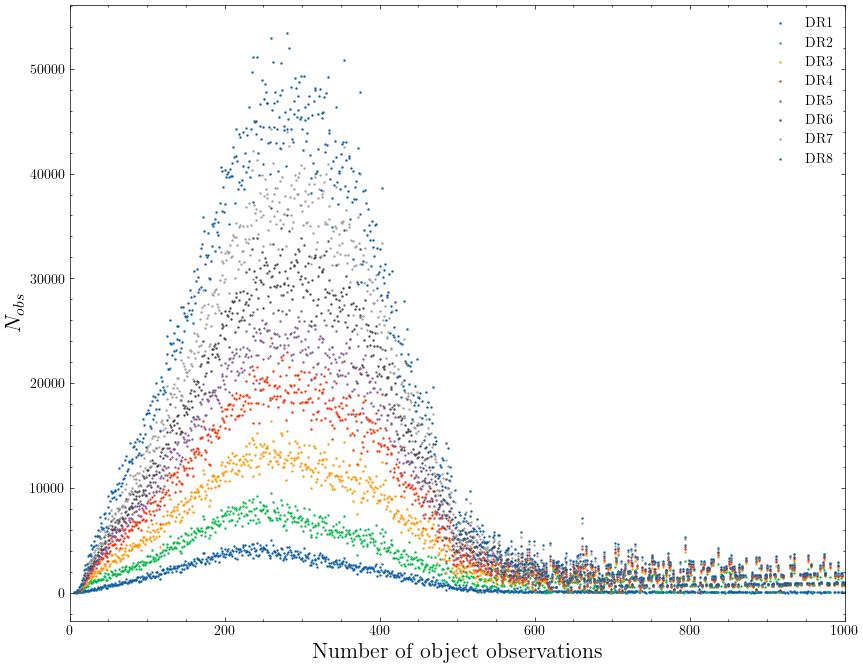

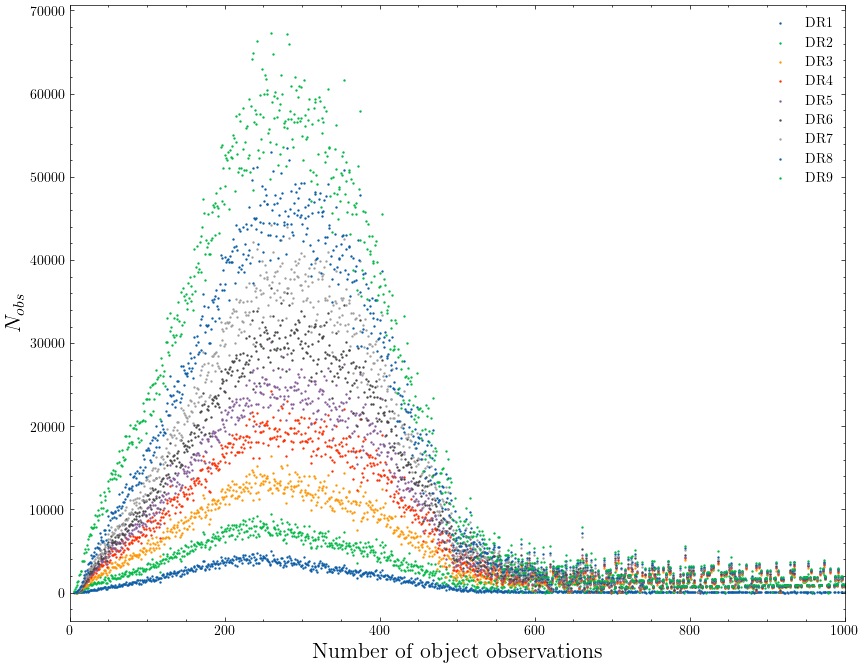

In [19]:
# These aren't quite right.

for region, condition in regions.items():
    yearly_detection_counts = []
    for date in catalog_dates:
        stmt = f'''
            select count(*), numObs
            from dp03_catalogs_10yr.DiaSource as ds
            inner join dp03_catalogs_10yr.SSObject as sso on sso.ssObjectId = ds.ssObjectId
            left outer join dp03_catalogs_10yr.MPCORB as mpc on mpc.ssObjectId = sso.ssObjectId
            where ds.midPointMjdTai >= {date[0]} and ds.midPointMjdTai <= {date[1]} and {condition}
            group by numObs
        '''
        yearly_detection_counts.append(query(stmt))
        fig, axs = plt.subplots(1, figsize=(10,8))
        for i, year in enumerate(yearly_detection_counts):
            axs.scatter(
                year["numObs"],
                year["count"],
                s=.5,
                label=f"DR{i + 1}"
            )
        axs.set_xlabel("Number of object observations", fontsize=16)
        axs.set_ylabel(r"$N_{obs}$", fontsize=16)
        lgnd = plt.legend()
        axs.set_ylim()
        axs.set_xlim(0, 1000)
        plt.savefig(f"{region}_mag_dist.png")

In [11]:
mb_df = pd.read_csv(
    "Main Belt_ap_mag_bins.csv", index_col=False
).drop(columns=["Unnamed: 0"])

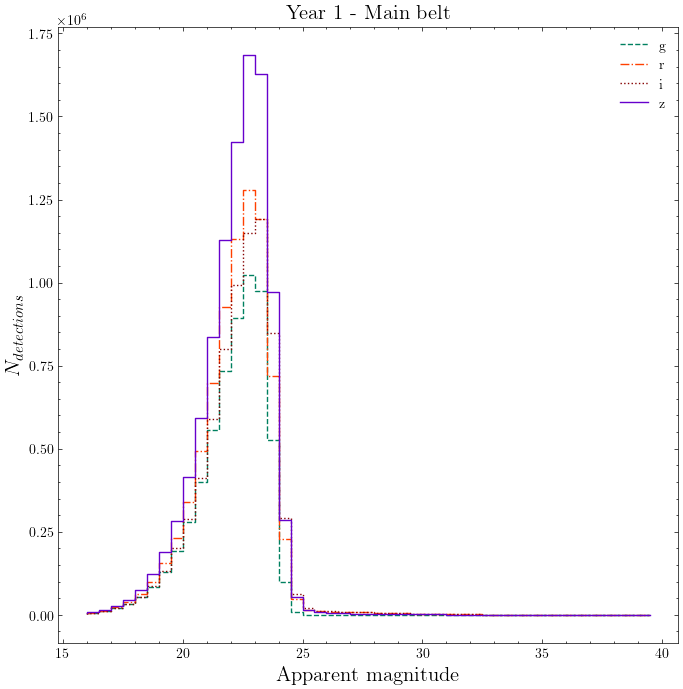

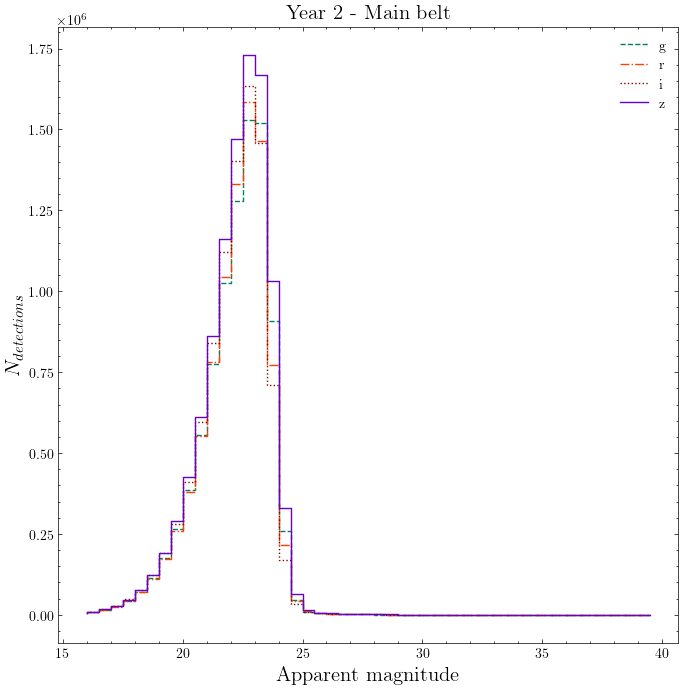

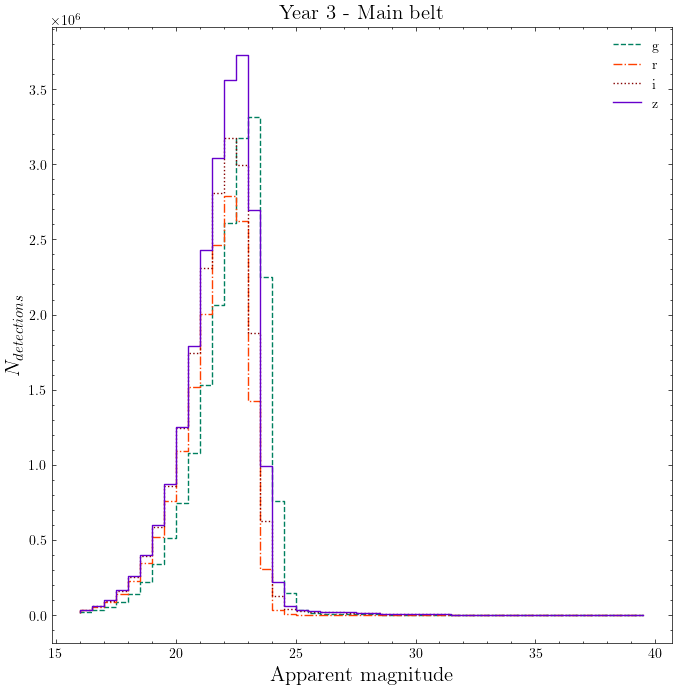

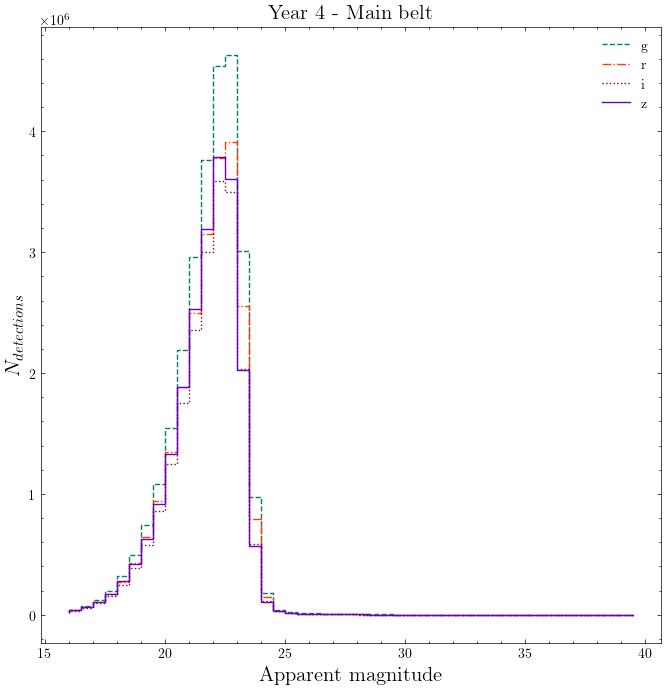

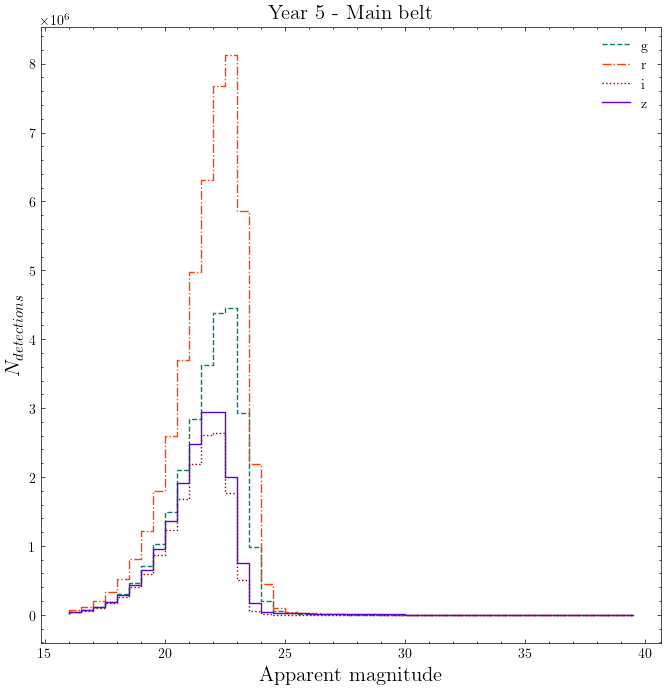

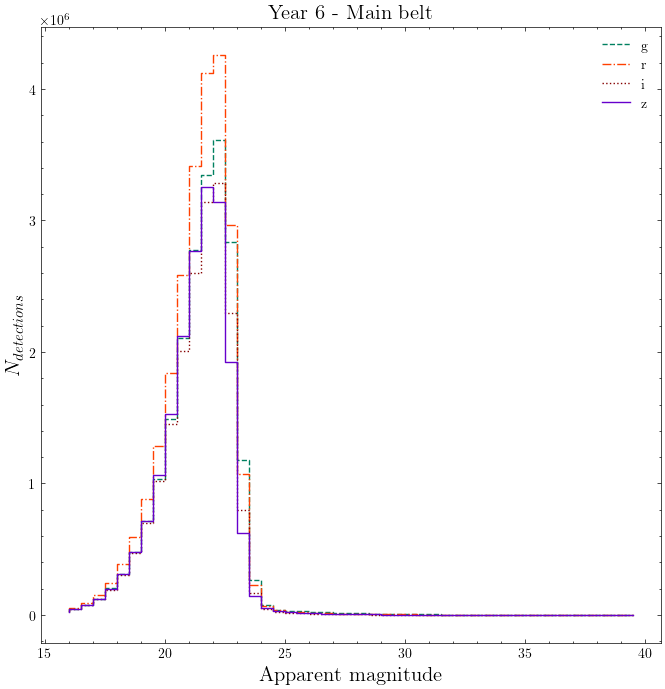

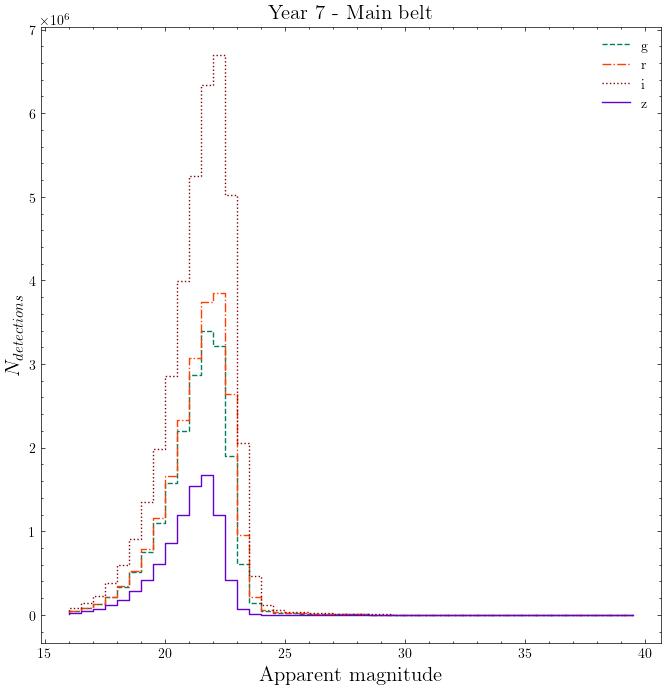

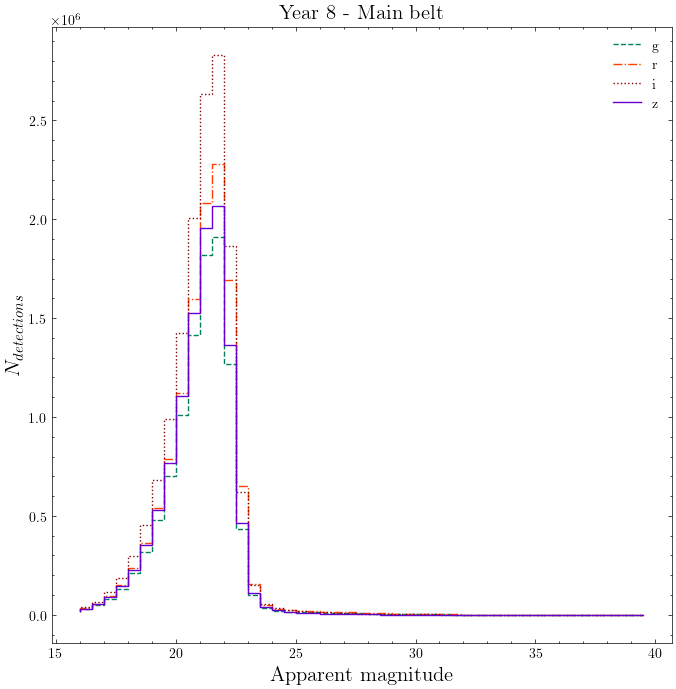

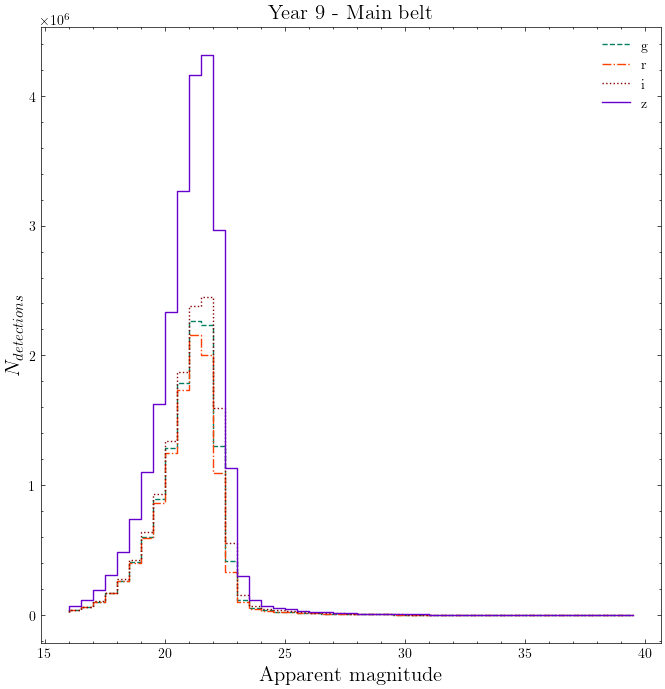

In [12]:
mb_df["bands"] = bands
cols = mb_df.columns
df_ = mb_df.drop(columns=["bands"])
xlabels = np.arange(16, 40, 0.5)

for i, _ in enumerate(years):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[mb_df["bands"] == filt].iloc[i], c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{detections}$", fontsize=15)
        plt.title(f"Year {i + 1} - Main belt", fontsize=15)
    plt.show()

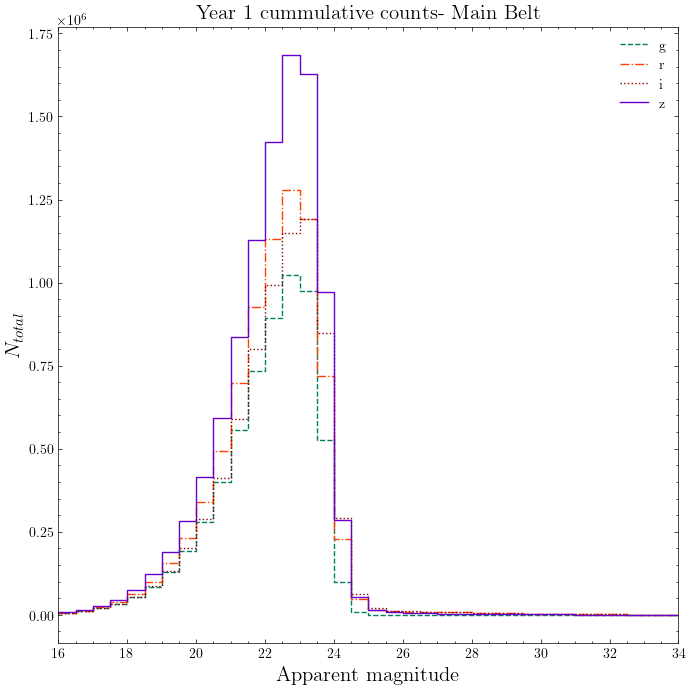

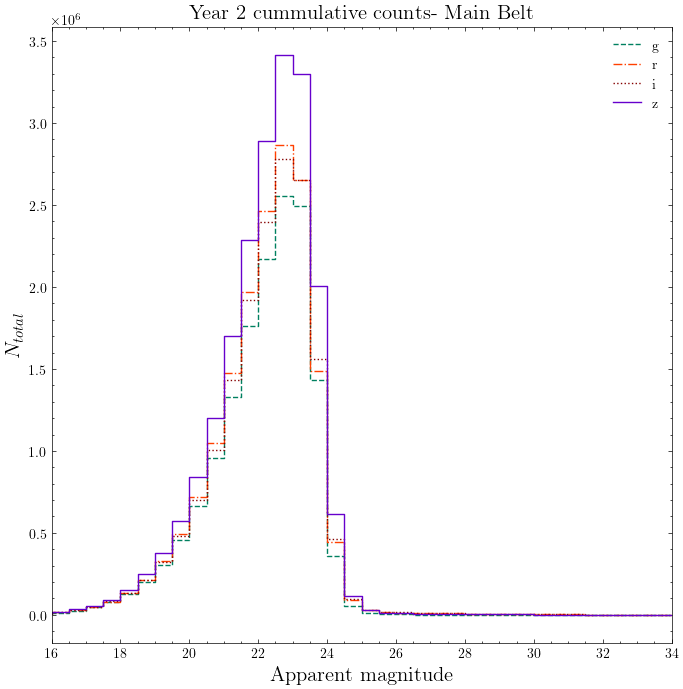

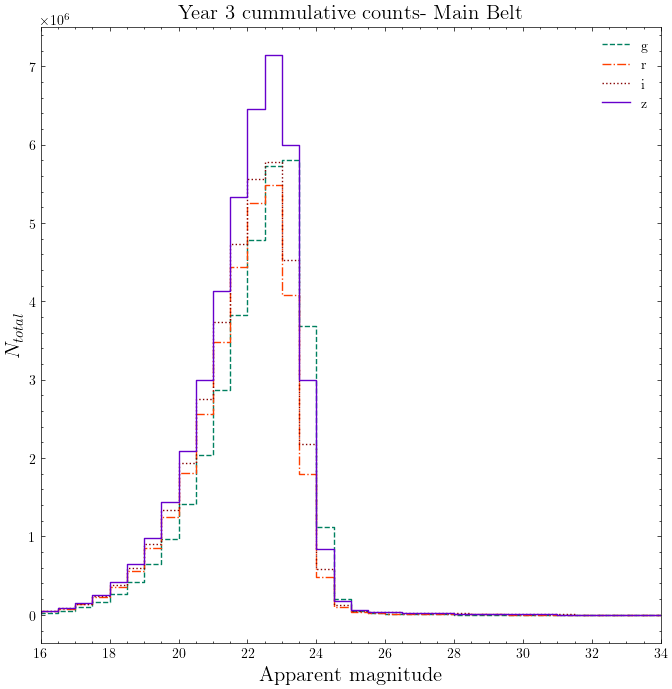

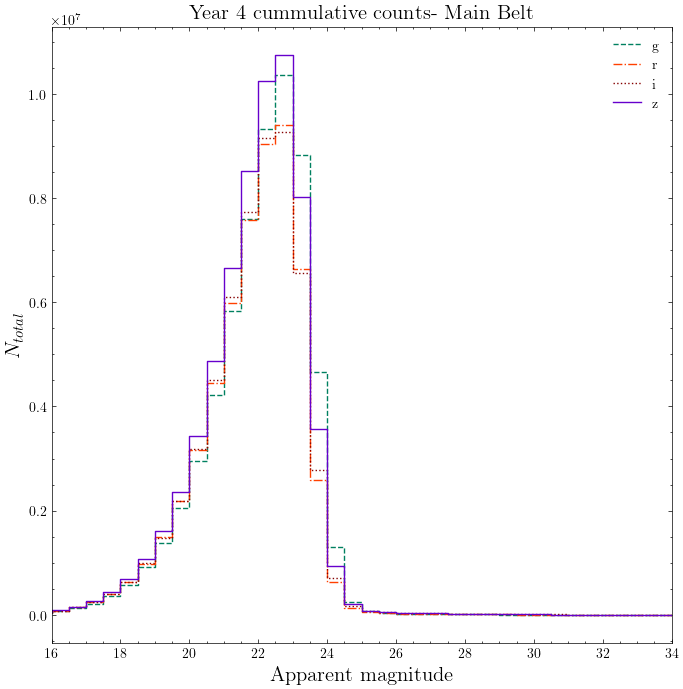

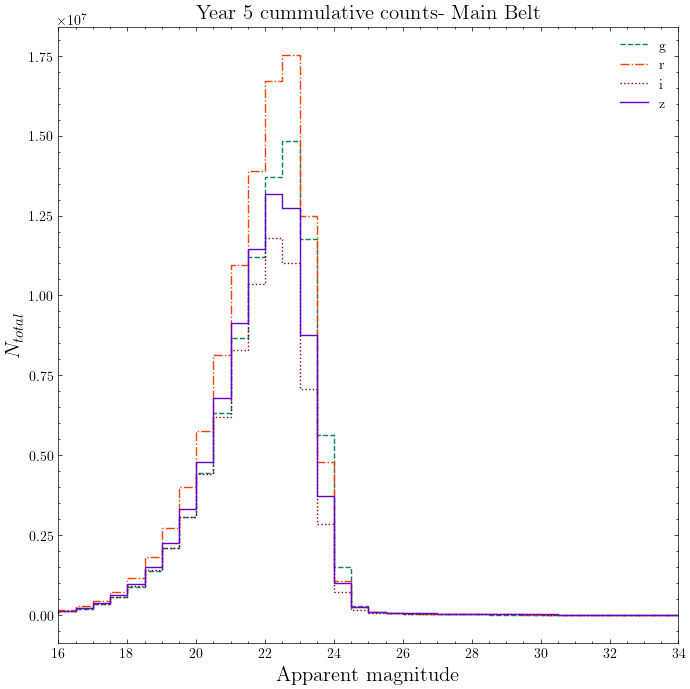

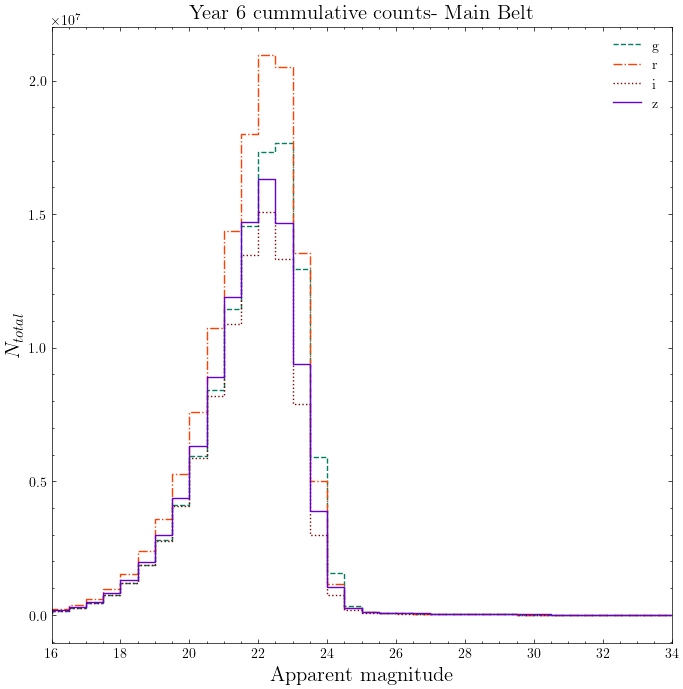

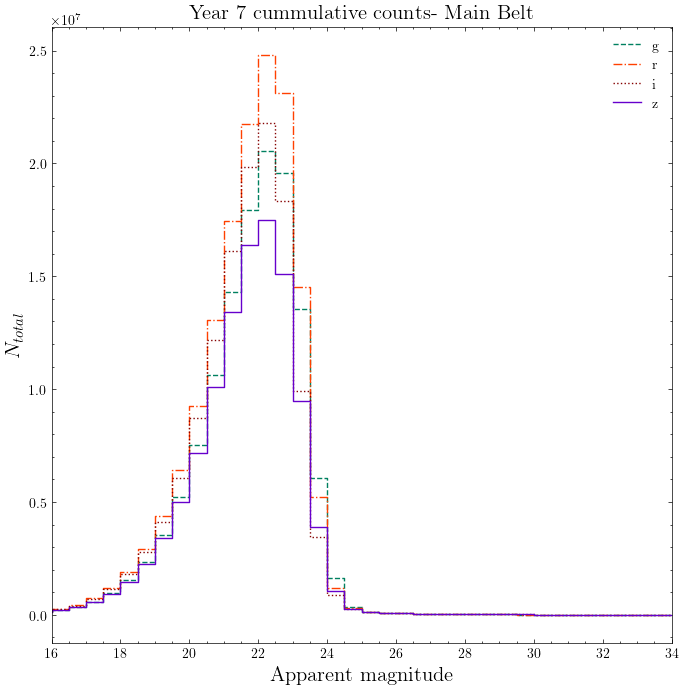

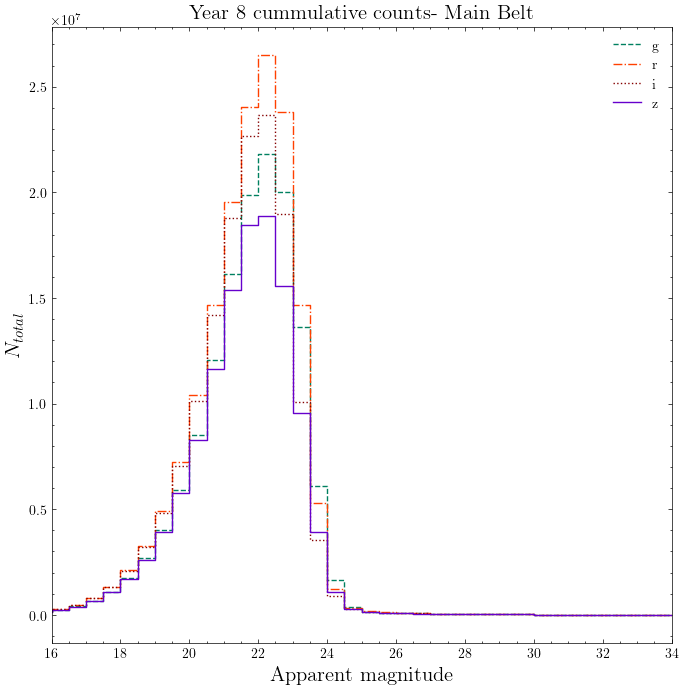

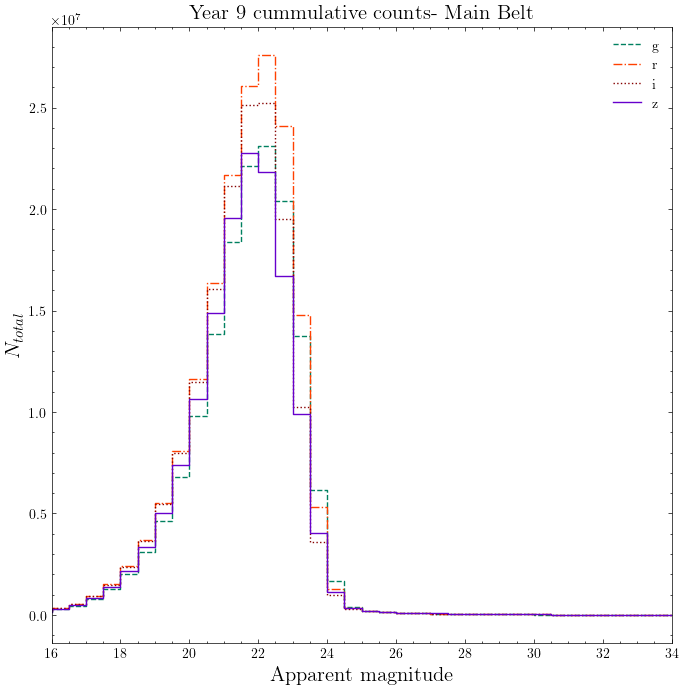

In [13]:
for i in range(1, len(years) + 1, 1):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[mb_df["bands"] == filt].iloc[0:i].sum() , c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i} cummulative counts- Main Belt", fontsize=15)
        plt.xlim(16,34)
    plt.show()

In [14]:
neo_df = pd.read_csv(
    "NEO_ap_mag_bins.csv", index_col=False
).drop(columns=["Unnamed: 0"])

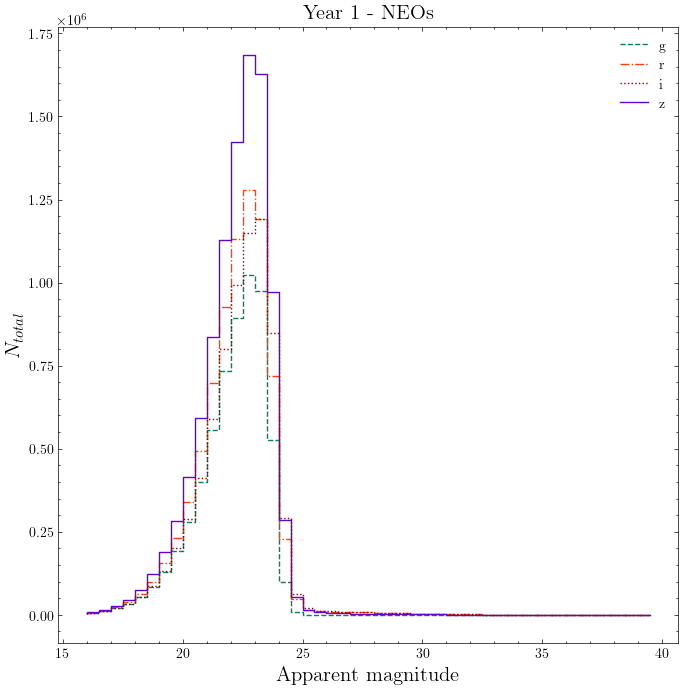

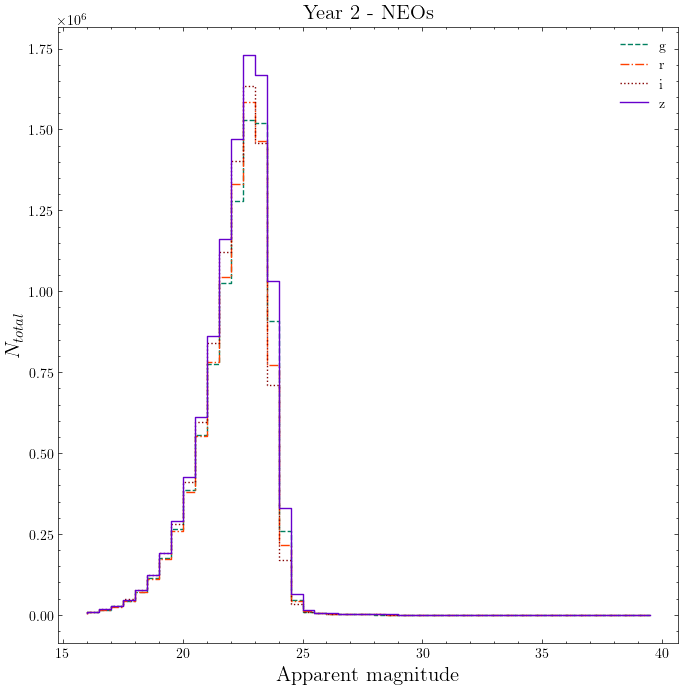

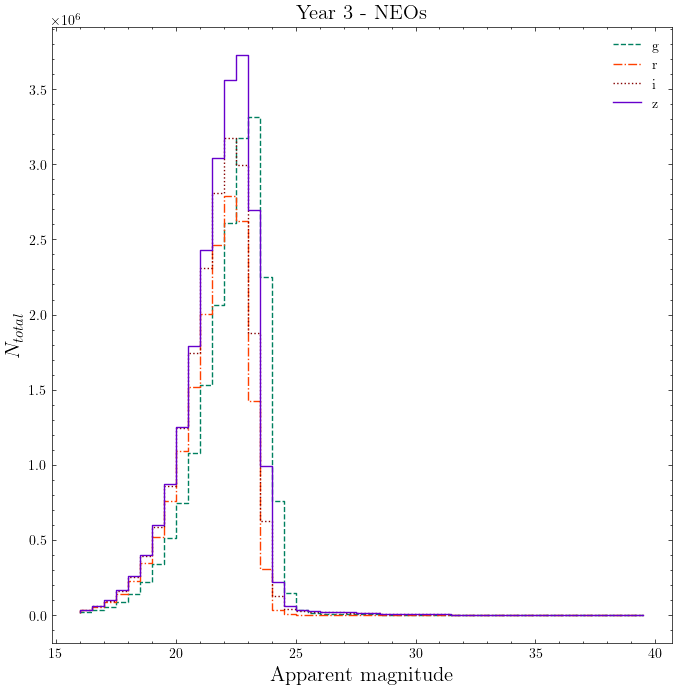

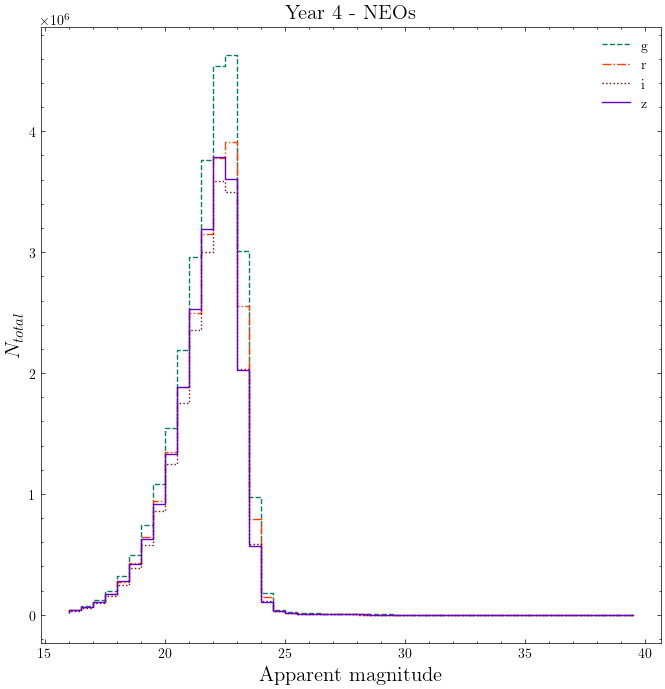

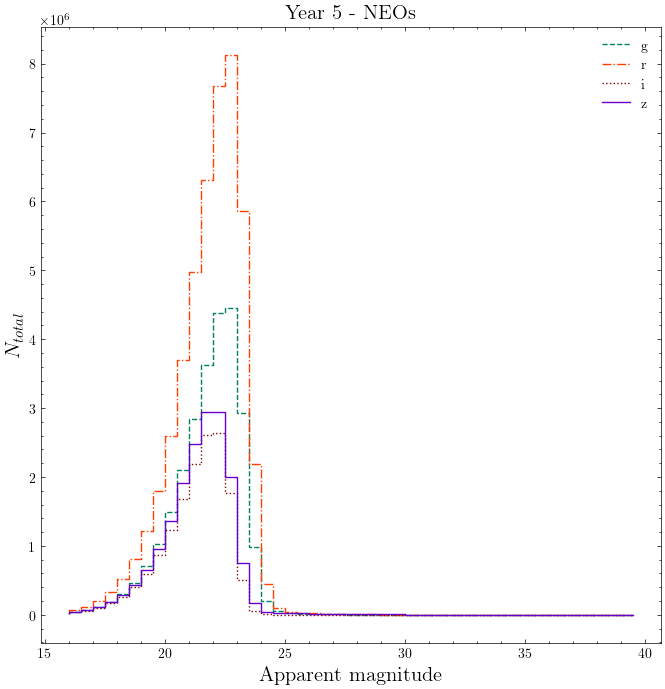

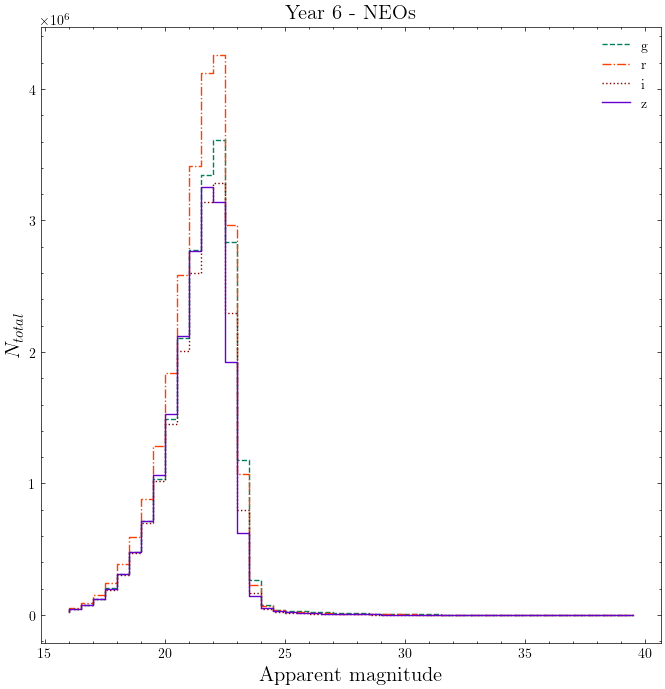

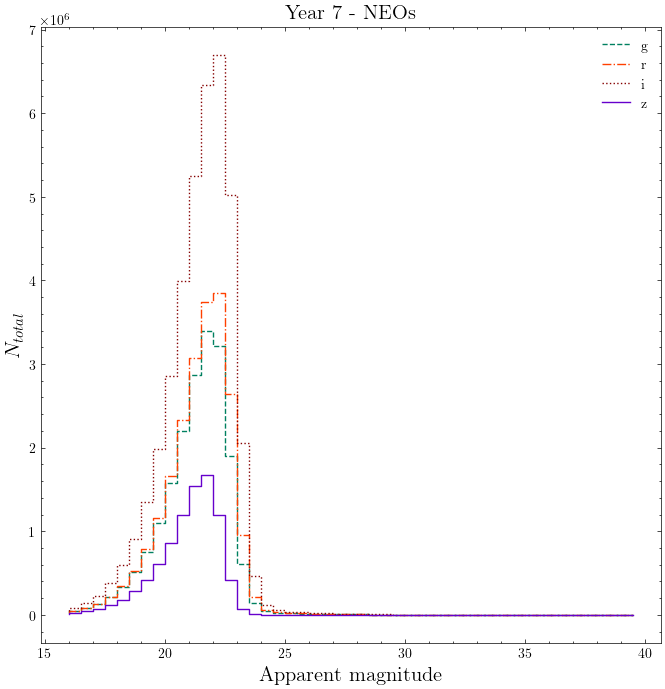

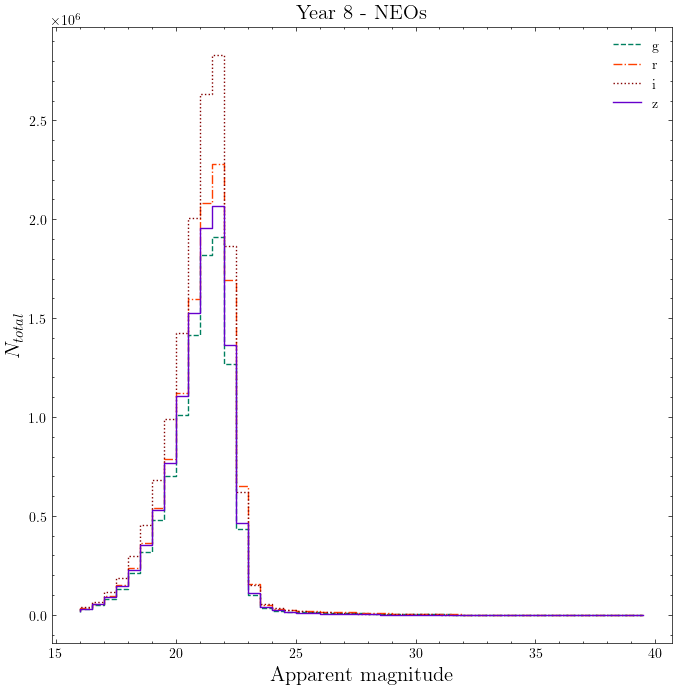

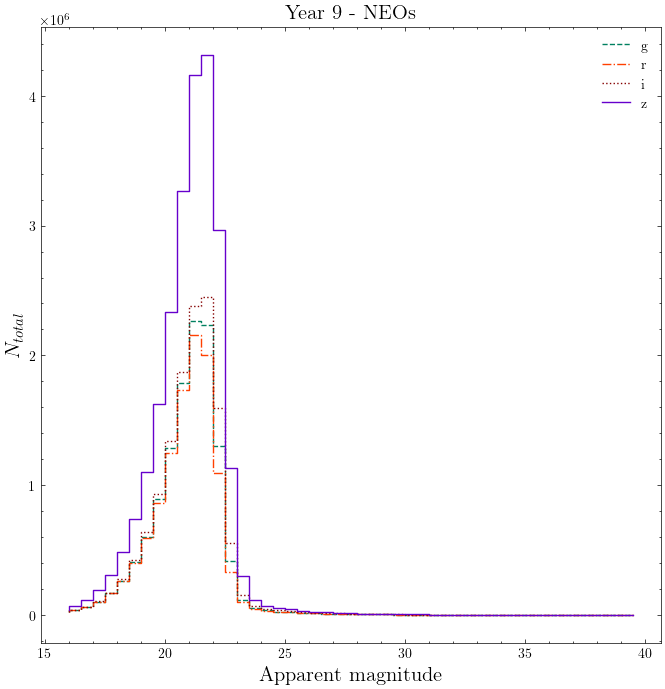

In [15]:
neo_df["bands"] = bands
cols = mb_df.columns
df_ = mb_df.drop(columns=["bands"])
xlabels = np.arange(16, 40, 0.5)

for i, _ in enumerate(years):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[neo_df["bands"] == filt].iloc[i], c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i + 1} - NEOs", fontsize=15)
    plt.show()

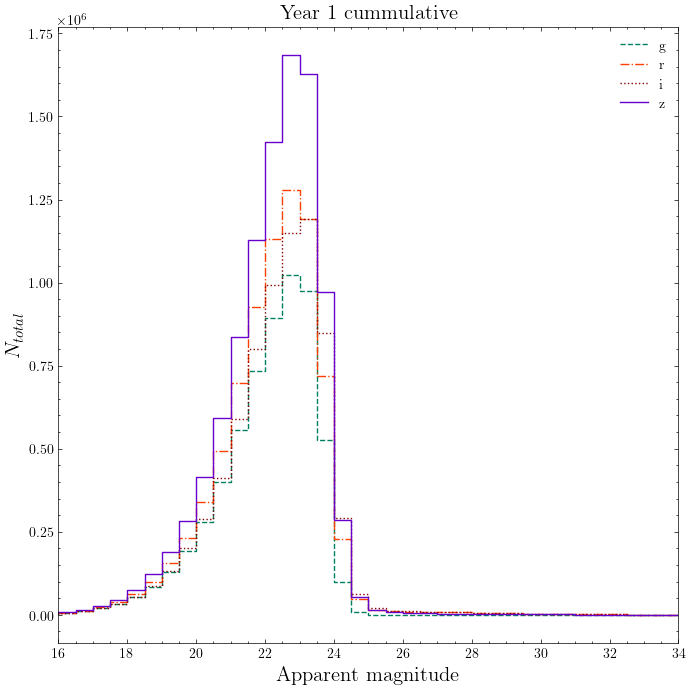

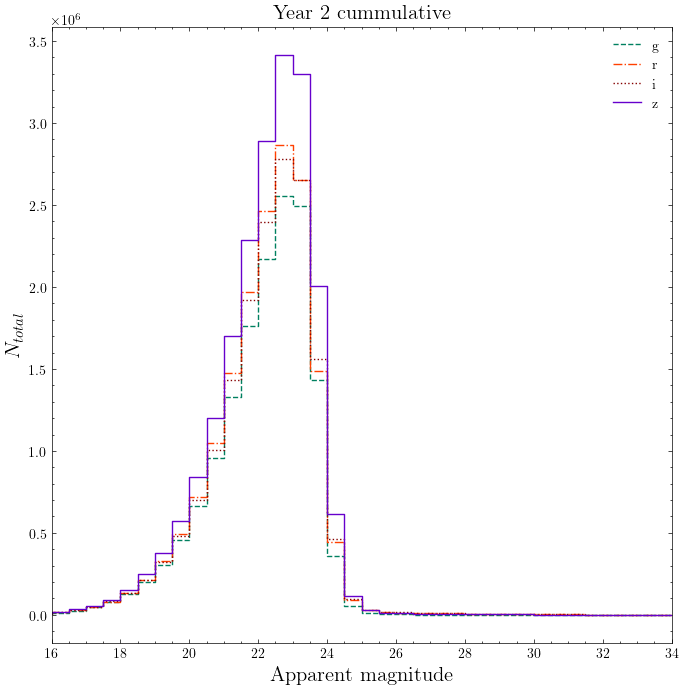

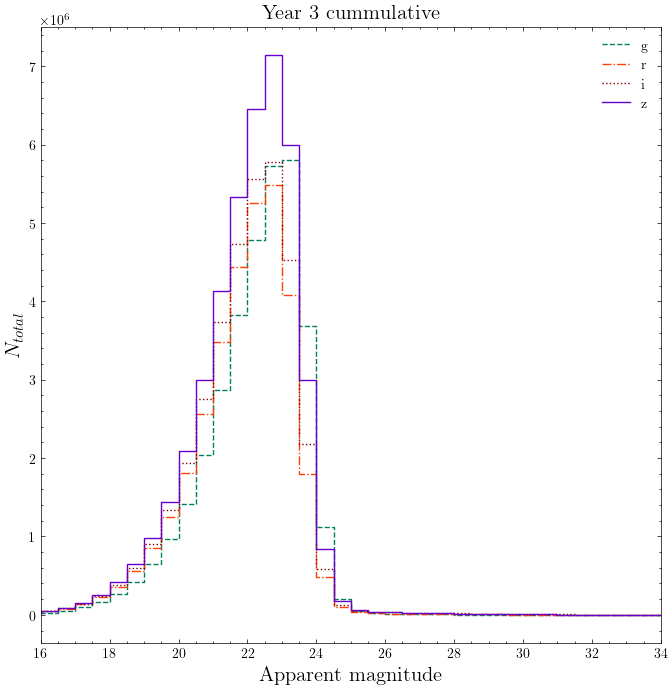

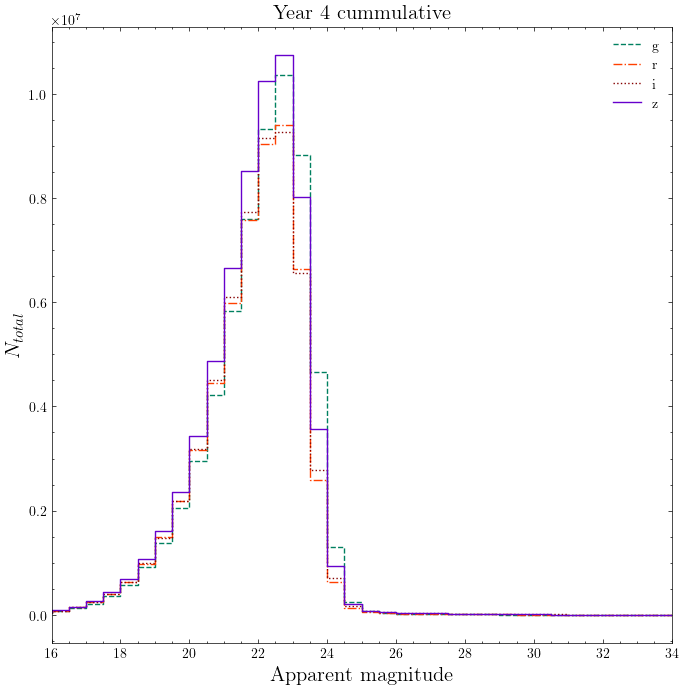

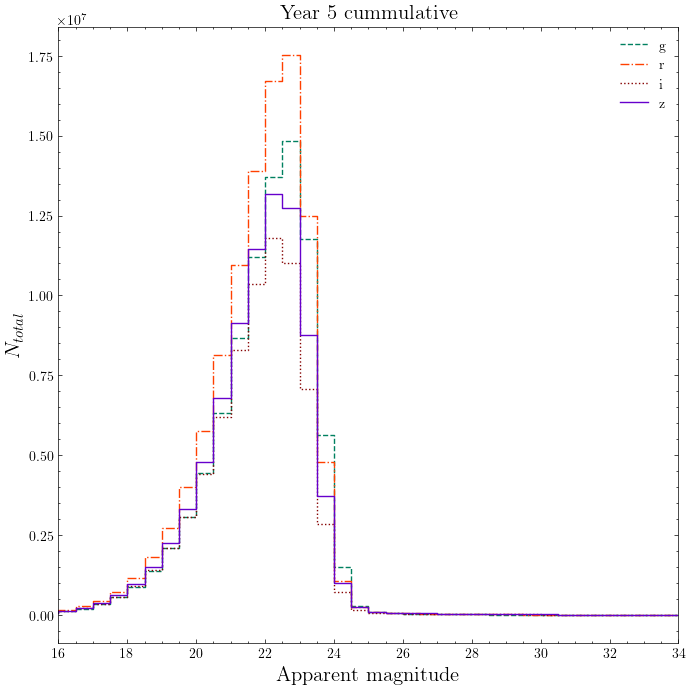

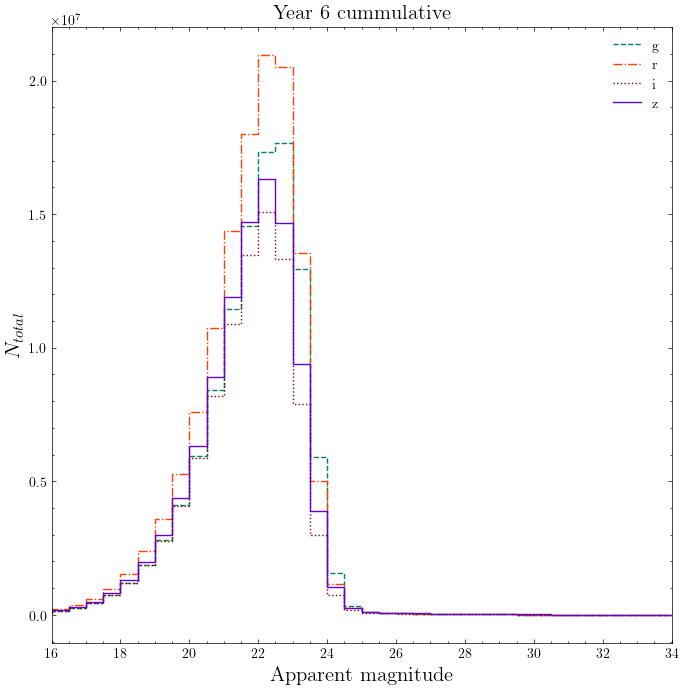

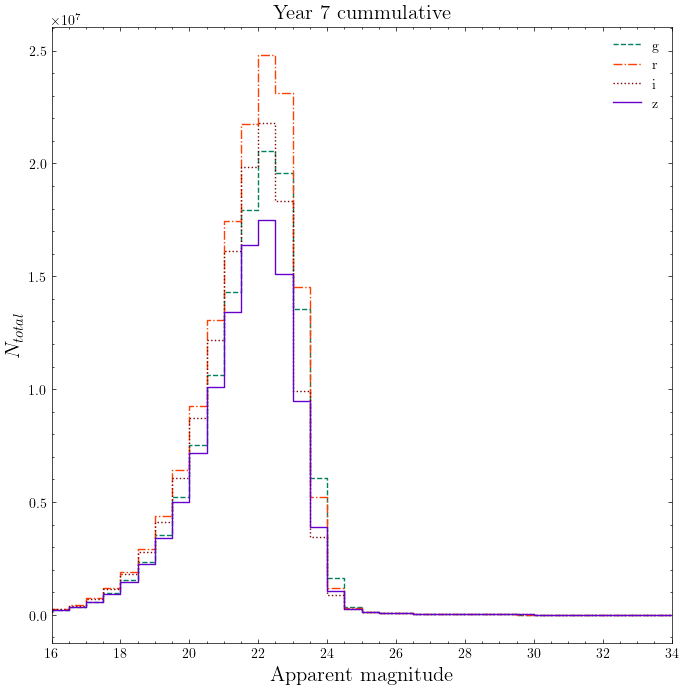

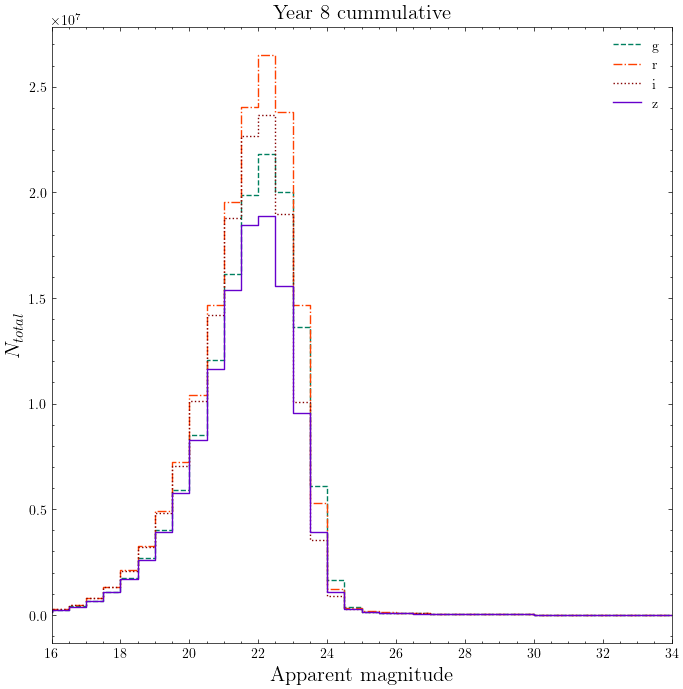

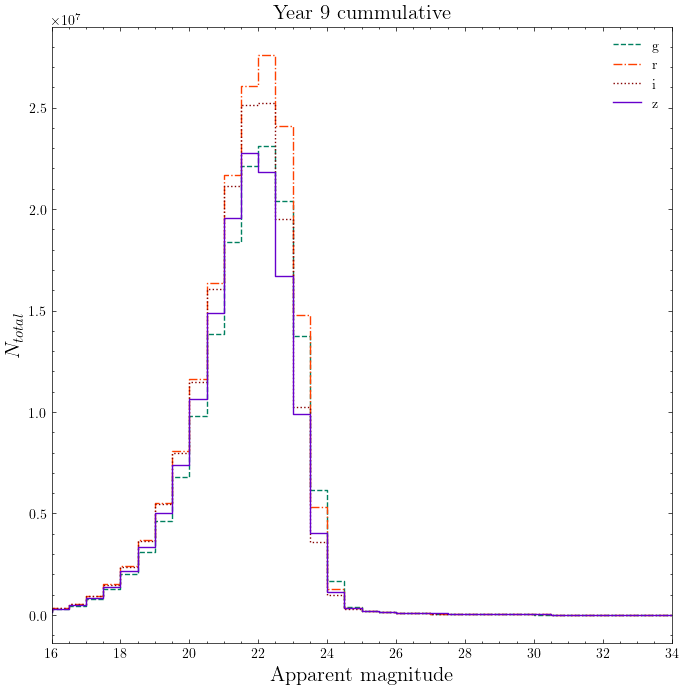

In [16]:
for i in range(1, len(years) + 1, 1):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[neo_df["bands"] == filt].iloc[0:i].sum() , c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i} cummulative", fontsize=15)
        plt.xlim(16,34)
    plt.show()

Magntidude vs magnitude error

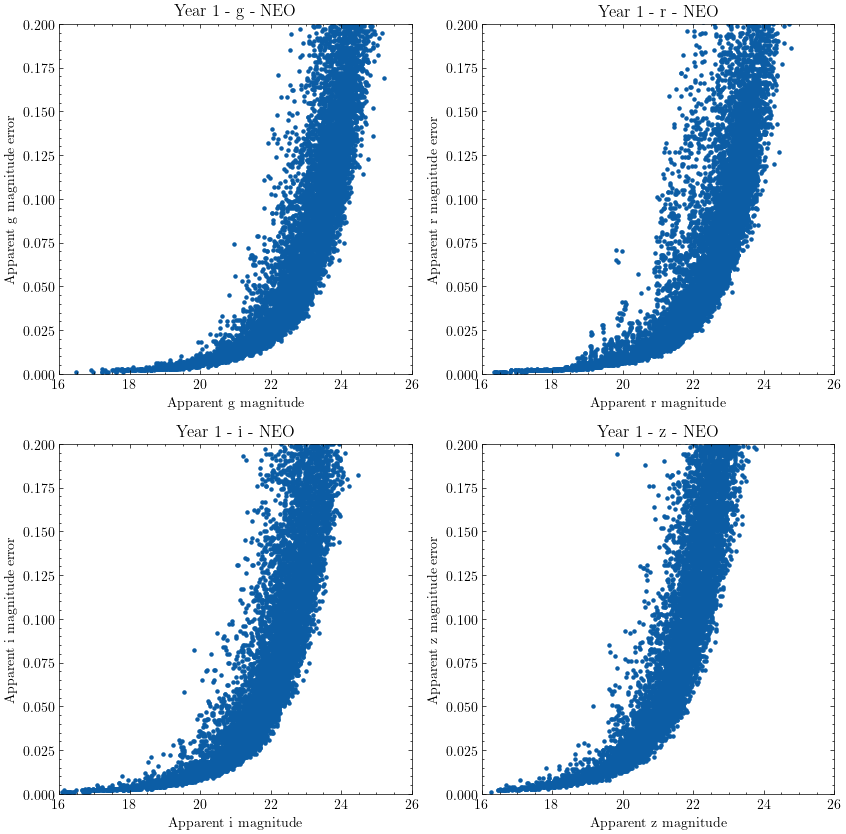

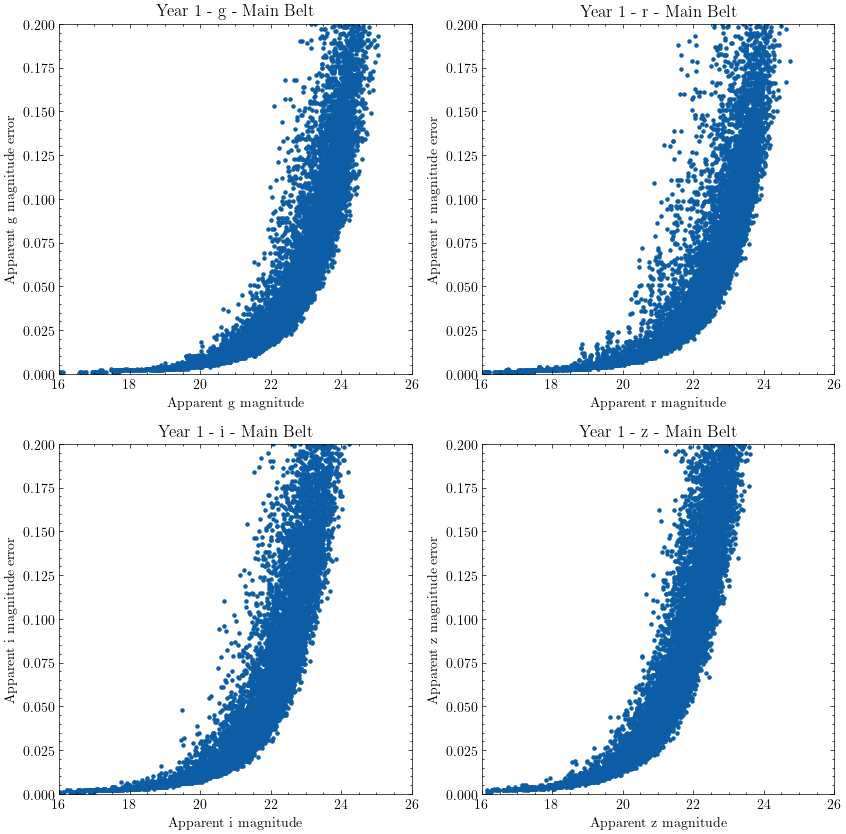

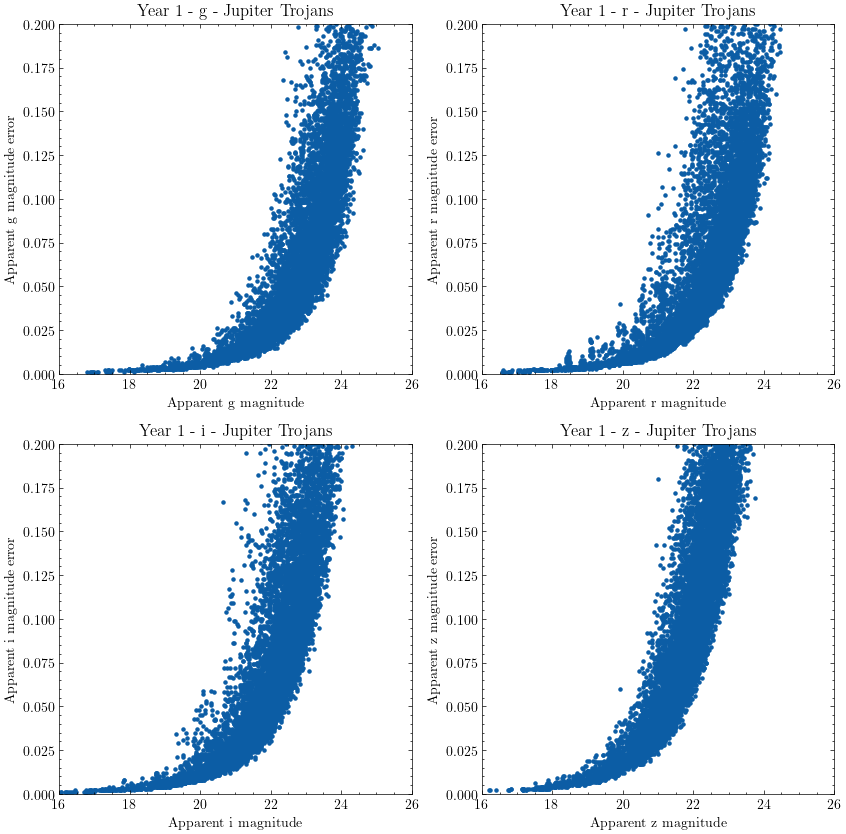

In [17]:
year = years[0]

for region, condition in regions.items():
    magErrDist = {
        "g":[], "r":[], "i":[], "z":[]
    }
    fig, axs = plt.subplots(2,2, figsize=(10,10))

    for filt in filters:
        magErrDist[filt].append(query(
            stmt = f'''
            SELECT mag, magErr
            FROM dp03_catalogs_10yr.DiaSource as ds
            JOIN dp03_catalogs_10yr.MPCORB as mpc ON mpc.ssObjectId = ds.ssObjectId
            WHERE midPointMjdTai >= {year[0][0]} and midPointMjdTai <= {year[1][0]} and band = '{filt}' and {condition}
            LIMIT 10000
            '''
        ))
    for i, ax in enumerate(axs.flat):
        ax.scatter(
            magErrDist[filters[i]][0]["mag"],
            magErrDist[filters[i]][0]["magErr"],
            s=5
            #bins=1000,
            #cmap=plt.cm.Reds
        )
        #plt.colorbar(label=r"$N_{obs}$")
        ax.set_xlim(16, 26)
        ax.set_ylim(0, 0.2)
        ax.set_xlabel(f"Apparent {filters[i]} magnitude")
        ax.set_ylabel(f"Apparent {filters[i]} magnitude error")
        ax.set_title(f"Year 1 - {filters[i]} -  {region}")
    plt.show()

Magnitude distributions

In [20]:
df = pd.read_csv("apMagBins.csv")
df["bands"] = bands
df.describe()

bin16          bin17          bin18         bin19  \
count      36.000000      36.000000      36.000000  3.600000e+01   
mean    52047.444444  155473.055556  412130.638889  9.778629e+05   
std     29439.573191   83222.466799  216506.618812  5.052945e+05   
min      6031.000000   31263.000000   87413.000000  2.176480e+05   
25%     34116.250000  107202.000000  284382.750000  6.746940e+05   
50%     55612.000000  166219.000000  436359.000000  1.019309e+06   
75%     65407.000000  193680.250000  507676.750000  1.205021e+06   
max    131031.000000  376827.000000  987276.000000  2.316117e+06   

              bin20         bin21         bin22         bin23         bin24  \
count  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01   
mean   2.107801e+06  4.085200e+06  5.673239e+06  3.836051e+06  7.038610e+05   
std    1.077015e+06  2.057841e+06  3.030586e+06  2.972244e+06  7.220641e+05   
min    4.835640e+05  9.845870e+05  1.695783e+06  4.576860e+05  1.744500e+04   
25%    1.451645e+06  2.796720e+06  3.209398e+06  1.960019e+06  1.715952e+05   
50%    2.183754e+06  4.237474e+06  5.521382e+06  3.268854e+06  4.851680e+05   
75%    2.597834e+06  5.061939e+06  7.277896e+06  5.445390e+06  1.093844e+06   
max    4.972236e+06  9.583401e+06  1.470042e+07  1.484207e+07  3.167619e+06   

               bin25  ...       bin41       bin42       bin43       bin44  \
count      36.000000  ...   36.000000   36.000000   36.000000   36.000000   
mean    59545.222222  ...   96.638889   75.861111   57.500000   45.388889   
std     35756.466606  ...   61.255975   47.119394   35.030191   29.421351   
min      2654.000000  ...    0.000000    0.000000    1.000000    0.000000   
25%     45918.500000  ...   63.000000   49.750000   38.750000   26.250000   
50%     55901.000000  ...   87.000000   68.000000   52.000000   39.500000   
75%     68834.250000  ...  132.500000  100.250000   79.000000   64.500000   
max    181683.000000  ...  258.000000  185.000000  140.000000  112.000000   

           bin45      bin46      bin47      bin48      bin49      bin50  
count  36.000000  36.000000  36.000000  36.000000  36.000000  36.000000  
mean   33.111111  27.277778  20.833333  16.250000  11.555556   9.444444  
std    20.626997  16.958118  13.840933  11.043744   7.240538   6.021127  
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
25%    19.000000  17.500000  12.500000   8.750000   6.750000   5.750000  
50%    31.500000  25.000000  19.000000  15.500000  11.500000   9.000000  
75%    45.500000  36.750000  28.500000  21.250000  16.500000  11.250000  
max    87.000000  71.000000  64.000000  42.000000  28.000000  26.000000  

[8 rows x 35 columns]

Yearly magnitude distributions across survey

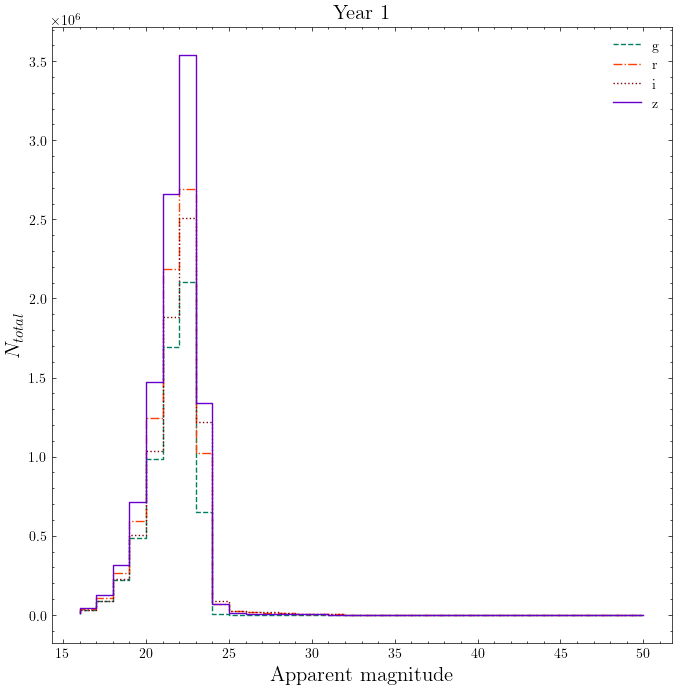

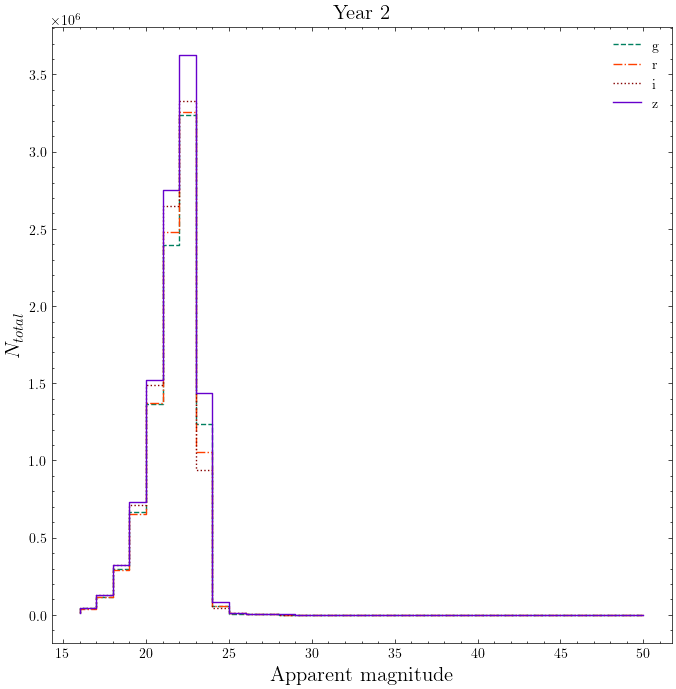

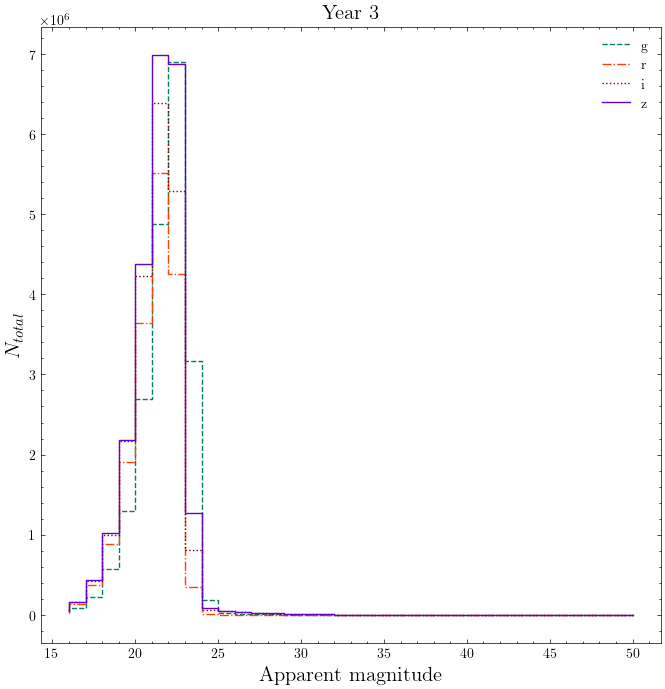

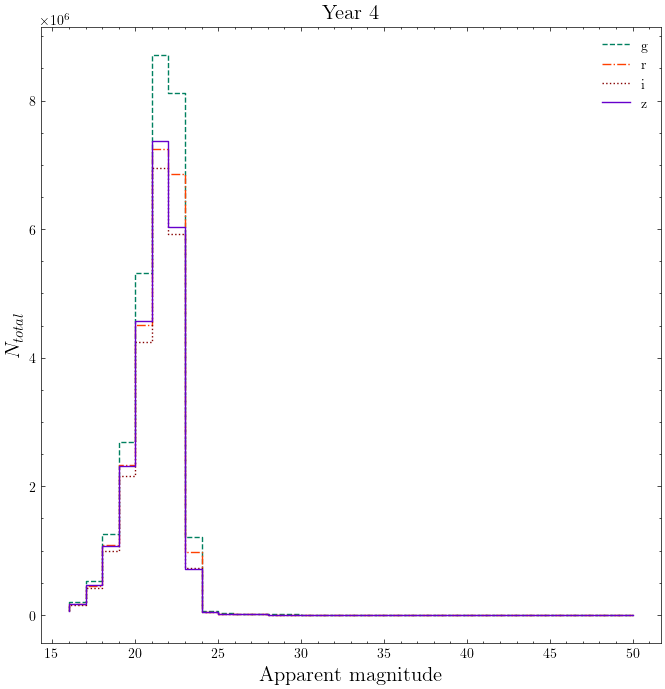

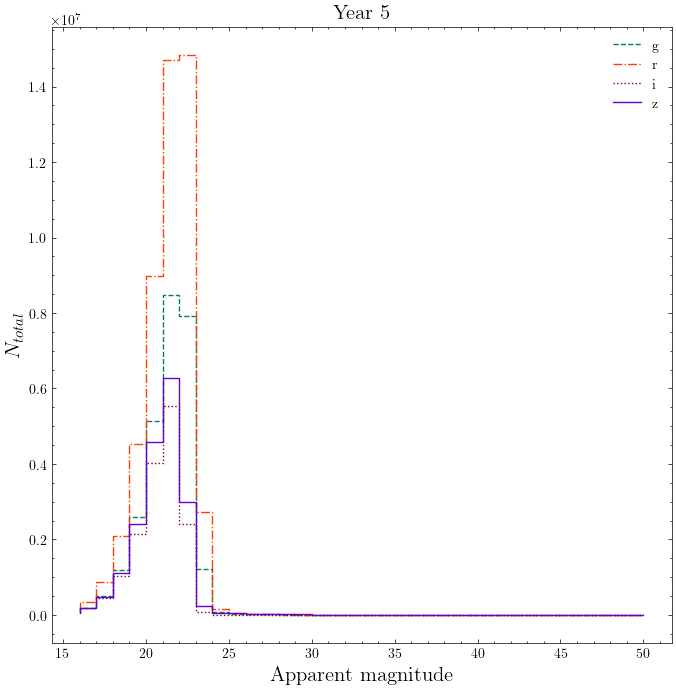

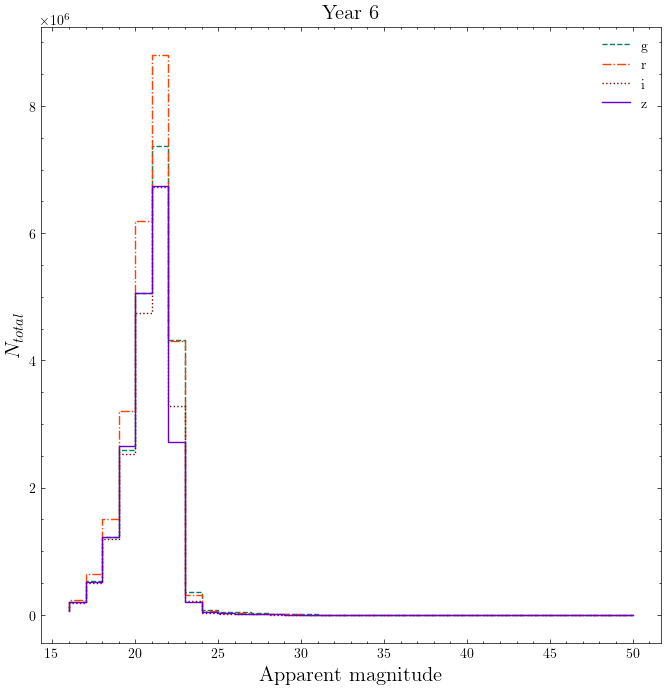

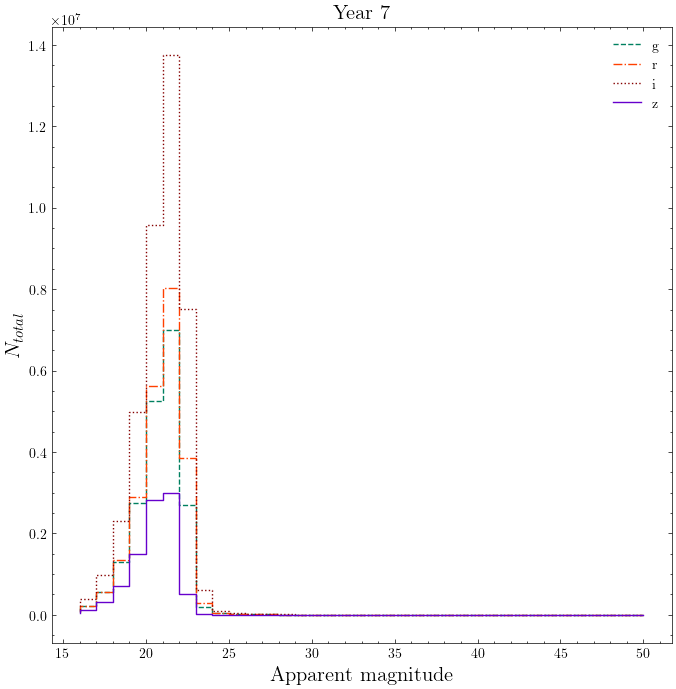

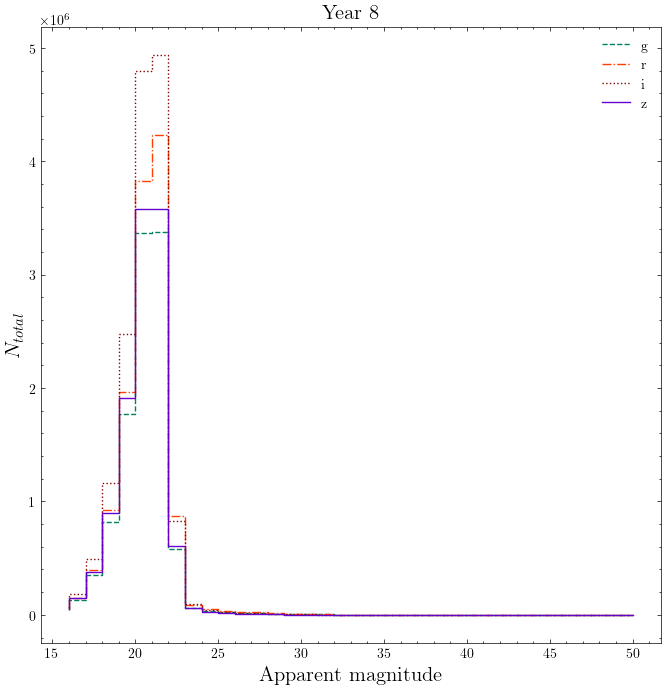

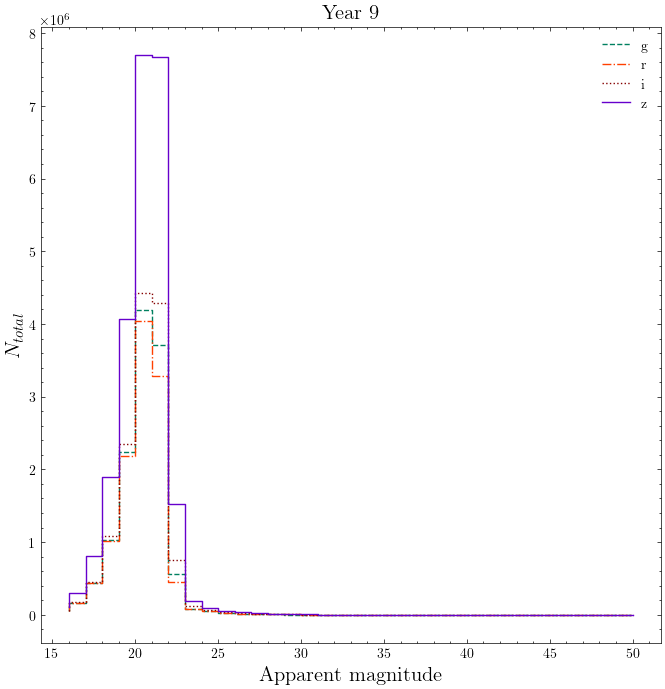

In [21]:
cols = df.columns
df_ = df.drop(columns=["bands"])
xlabels = [int(col.split("bin")[1]) for col in df_.columns]

for i, _ in enumerate(years):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[df["bands"] == filt].iloc[i], c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i + 1}", fontsize=15)
    plt.show()

Cummulative magnitude distributions

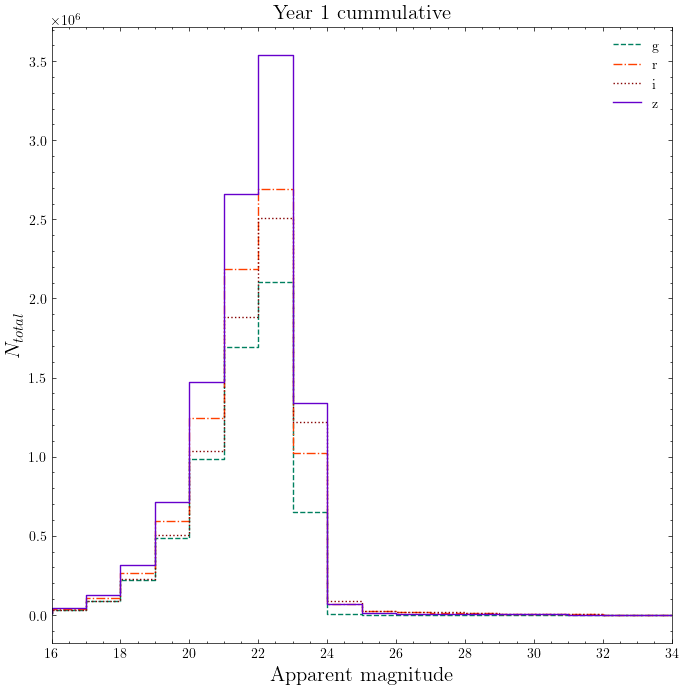

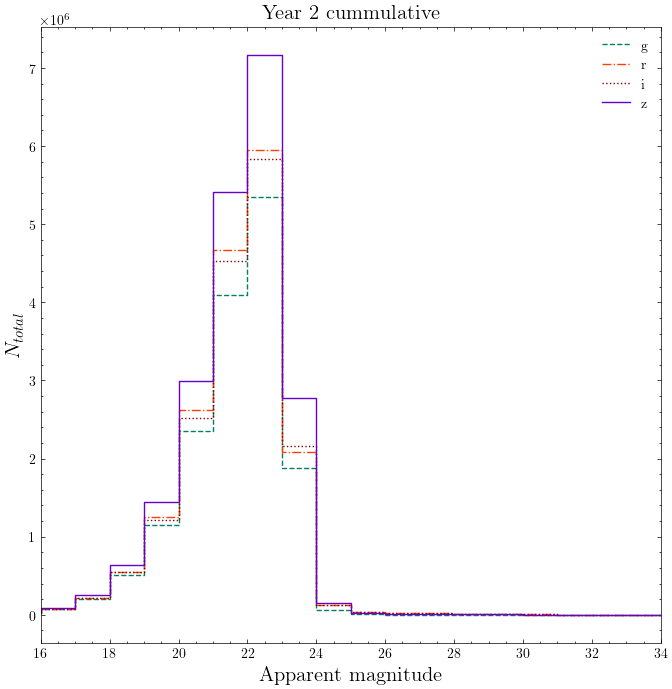

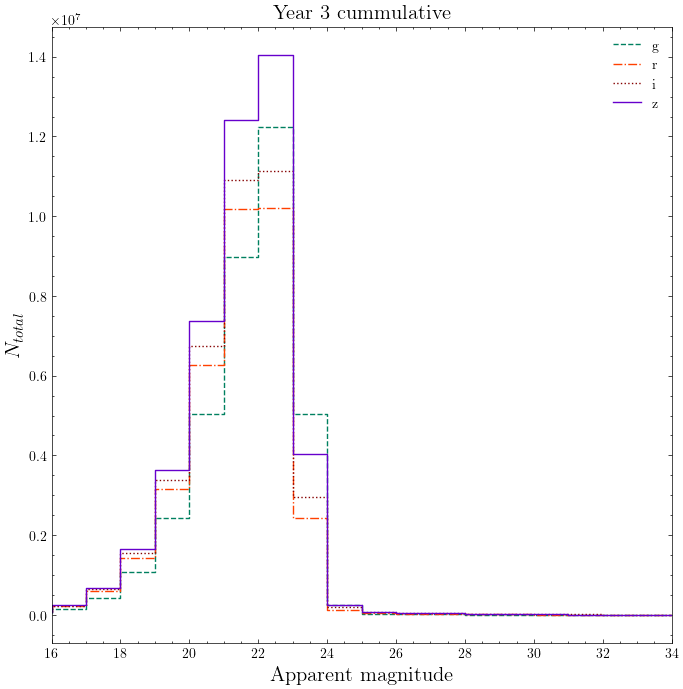

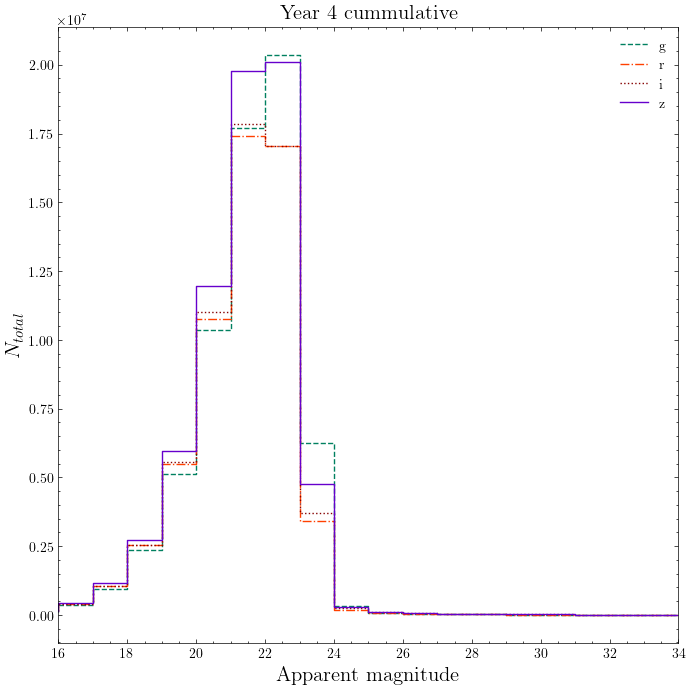

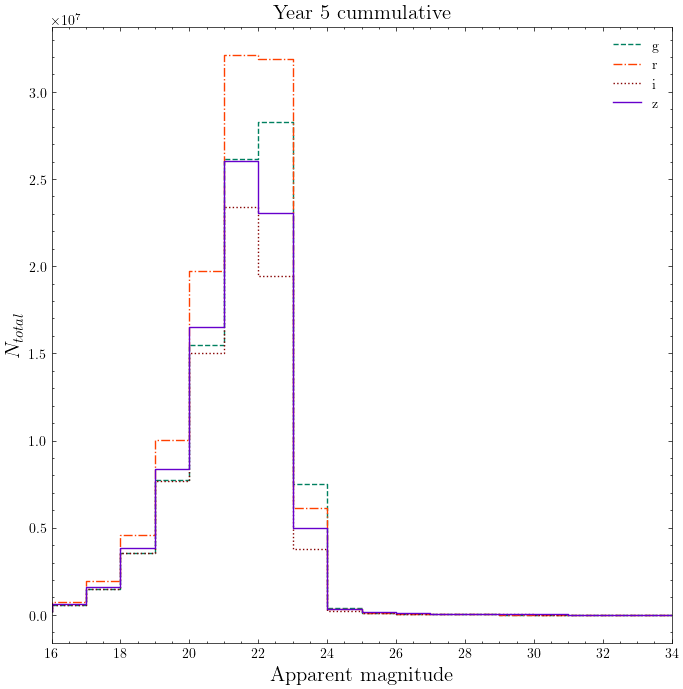

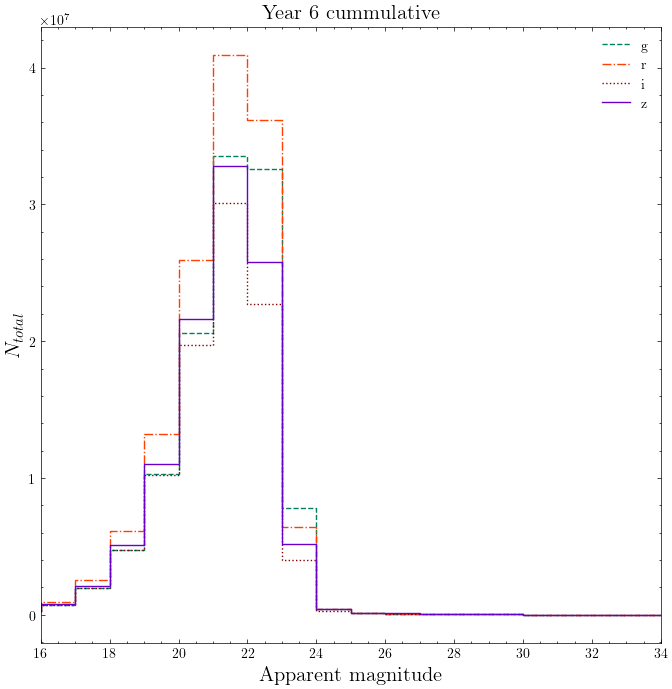

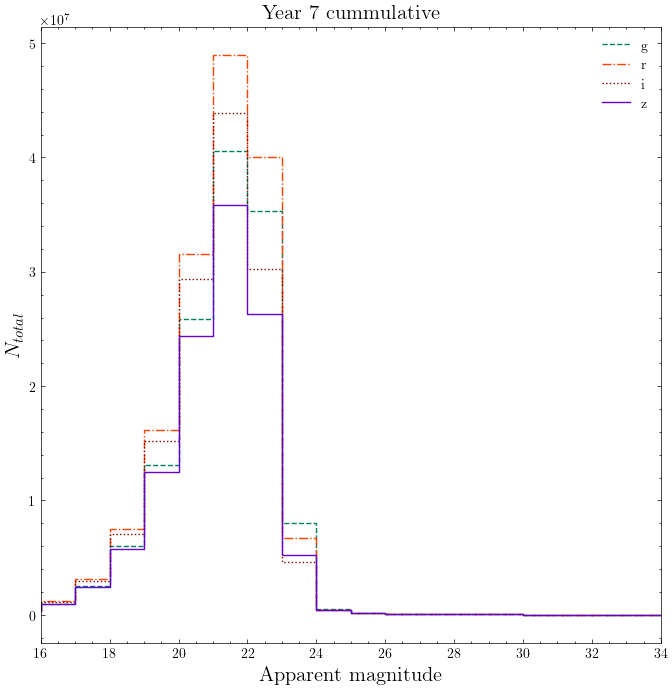

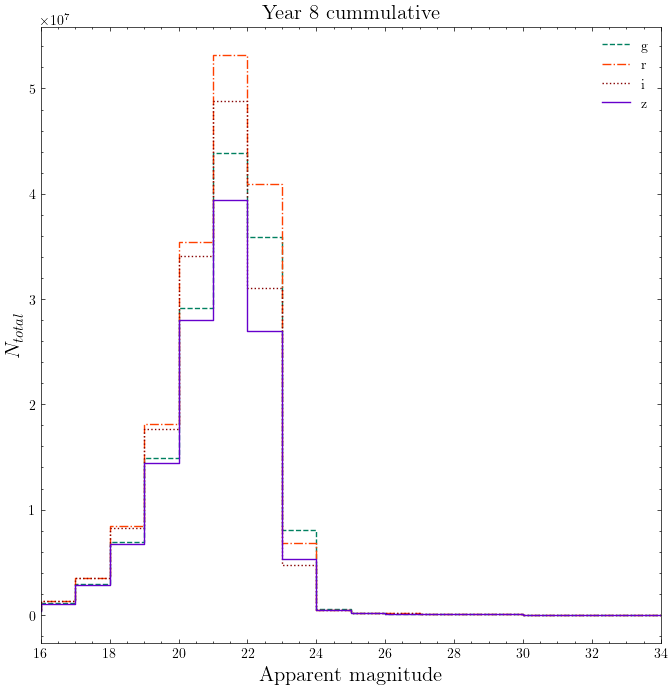

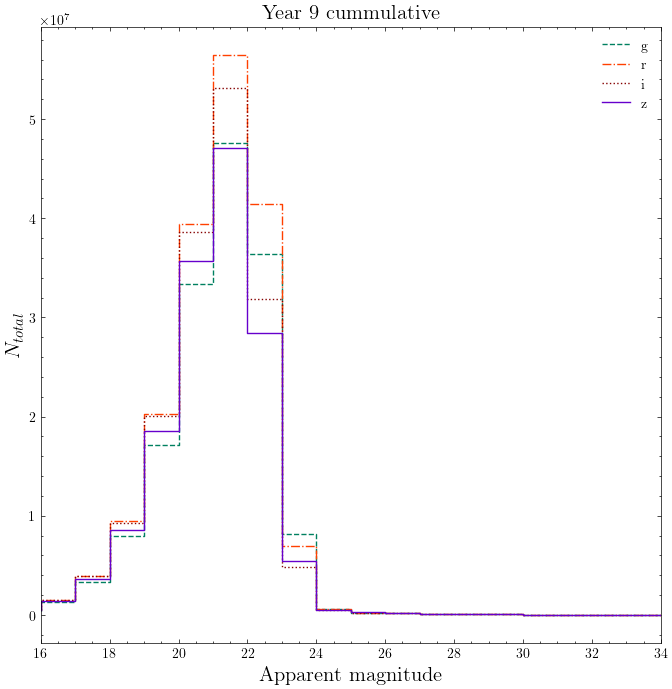

In [22]:
for i in range(1, len(years) + 1, 1):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[df["bands"] == filt].iloc[0:i].sum() , c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i} cummulative", fontsize=15)
        plt.xlim(16,34)
    plt.show()

"Wonky" magnitudes

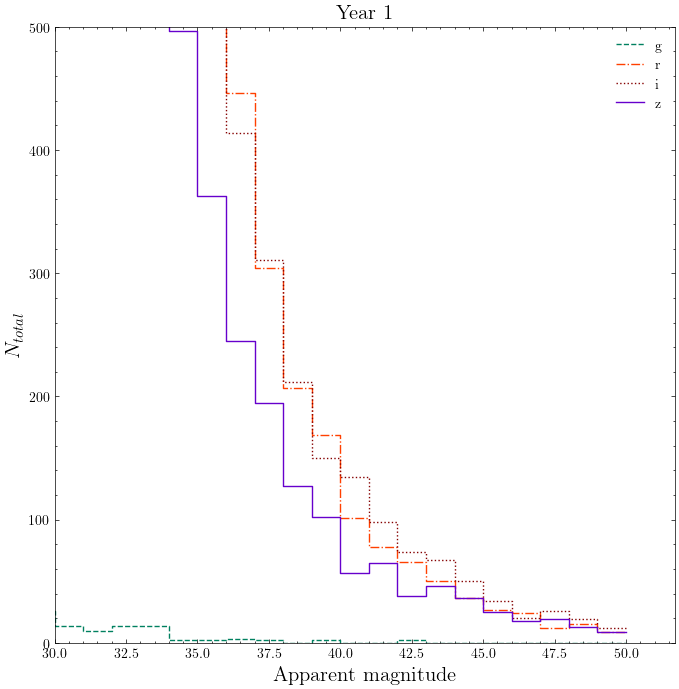

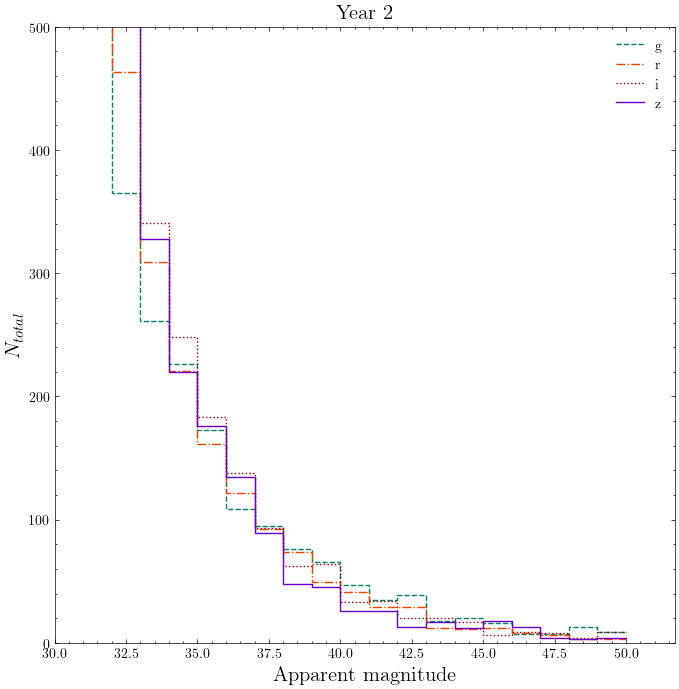

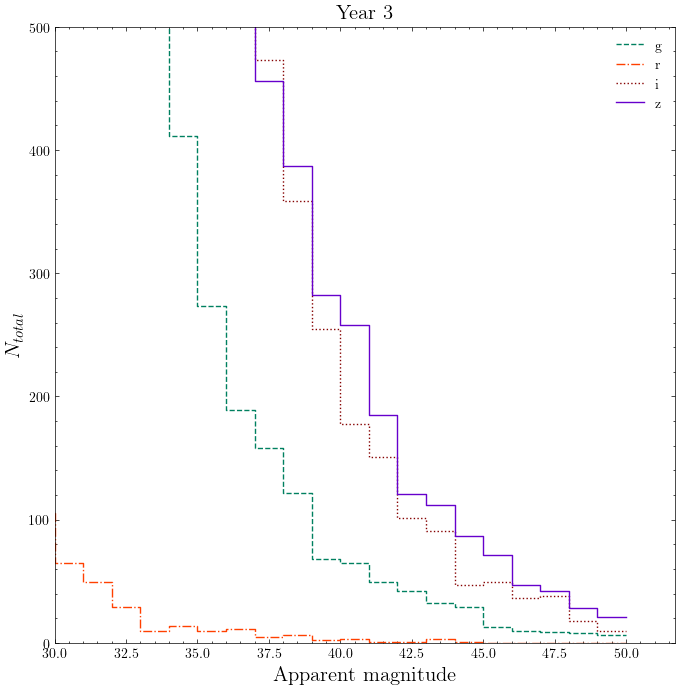

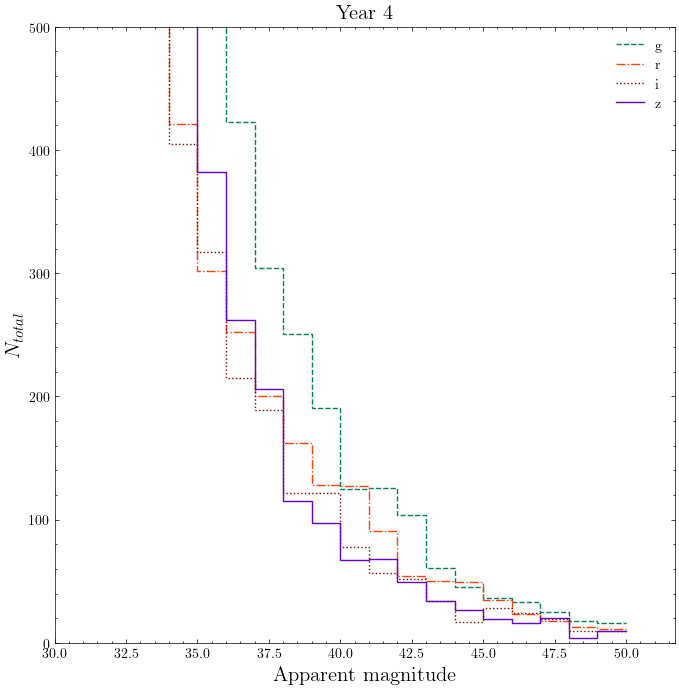

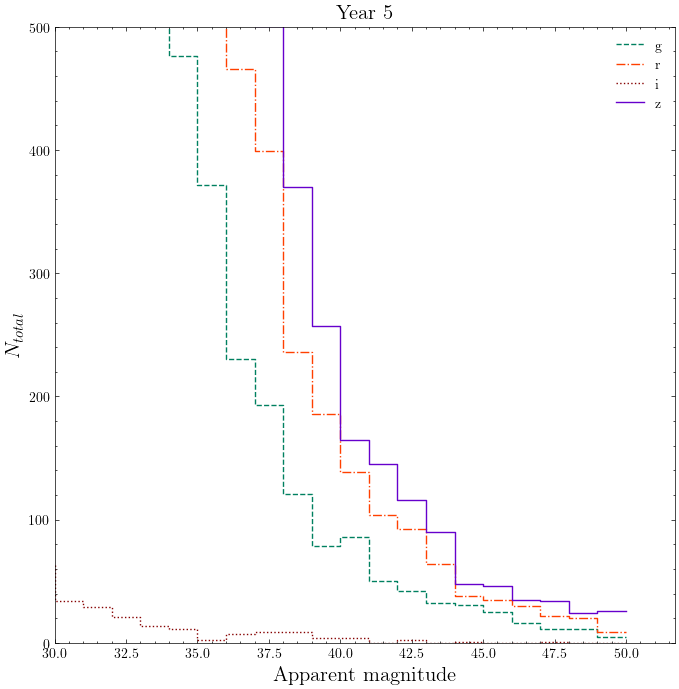

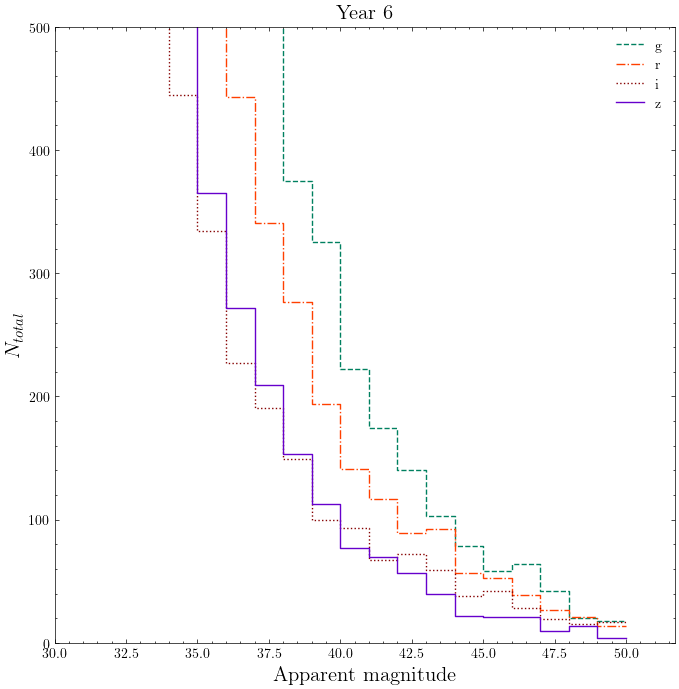

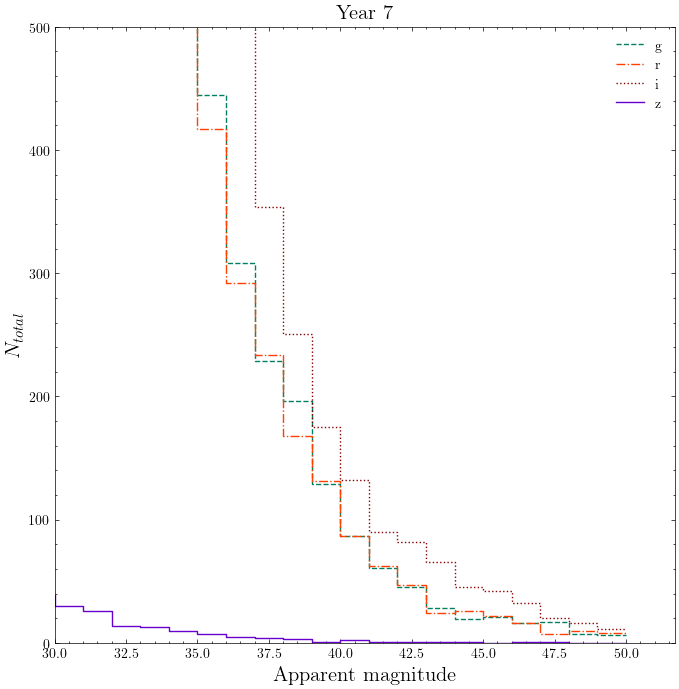

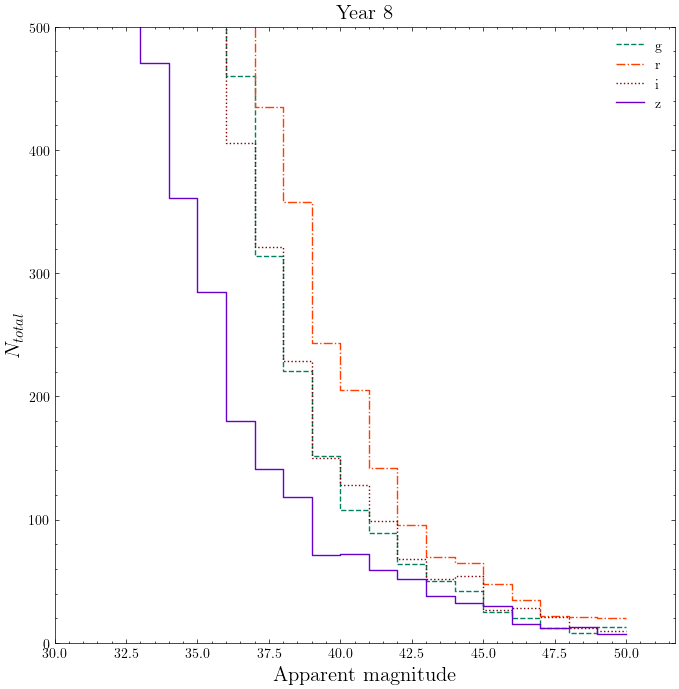

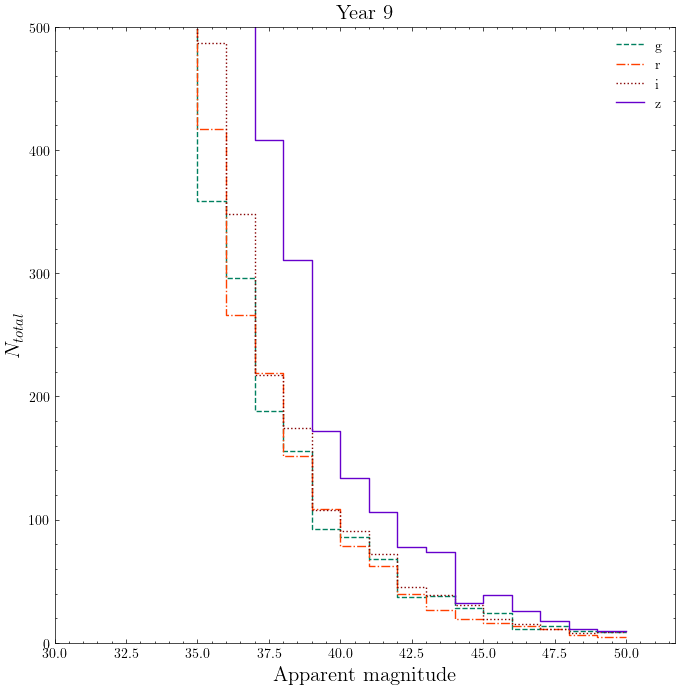

In [23]:
cols = df.columns
df_ = df.drop(columns=["bands"])
xlabels = [int(col.split("bin")[1]) for col in df_.columns]

for i, _ in enumerate(years):
    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.step(xlabels, df_[df["bands"] == filt].iloc[i], c=filter_colors[filt], label=filt, linestyle=linestyles[filt])
        plt.legend()
        plt.xlabel("Apparent magnitude", fontsize=15)
        plt.ylabel(r"$N_{total}$", fontsize=15)
        plt.title(f"Year {i + 1}", fontsize=15)
        plt.xlim(30, )
        plt.ylim(0, 500)
    plt.show()